In [4]:
# data manipulation
import pandas as pd
import numpy as np
import scipy.stats as stats
import itertools

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['axes.titlepad'] = 12
plt.rcParams['figure.dpi'] = 150
mpl.rcParams['font.family'] = 'Serif'

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from feature_engine.discretisation import EqualFrequencyDiscretiser
from category_encoders.woe import WOEEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

In [5]:
# !pip install feature_engine

### Introduction

The objective of this notebook is solely for my personal learning. However, I am making it available to others who might find it interesting and would like to offer feedback. I have a strong interest in Feature Engineering, but sometimes it can be unproductive and excessively time-consuming. In this notebook, I will build a model to predict whether a person has diabetes or not. First, I will leave the dataset unchanged and then compare the results with a model created after conducting a thorough analysis of the dataset and applying Feature Engineering where necessary.

In [6]:
# reading file
data = pd.read_csv('../input/diabetes-dataset/diabetes.csv')
all_features = [i for i in data.columns]
features = [i for i in data.columns if i != 'Outcome']
target = 'Outcome'

### Version 1 : without feature engineering or pre-processing

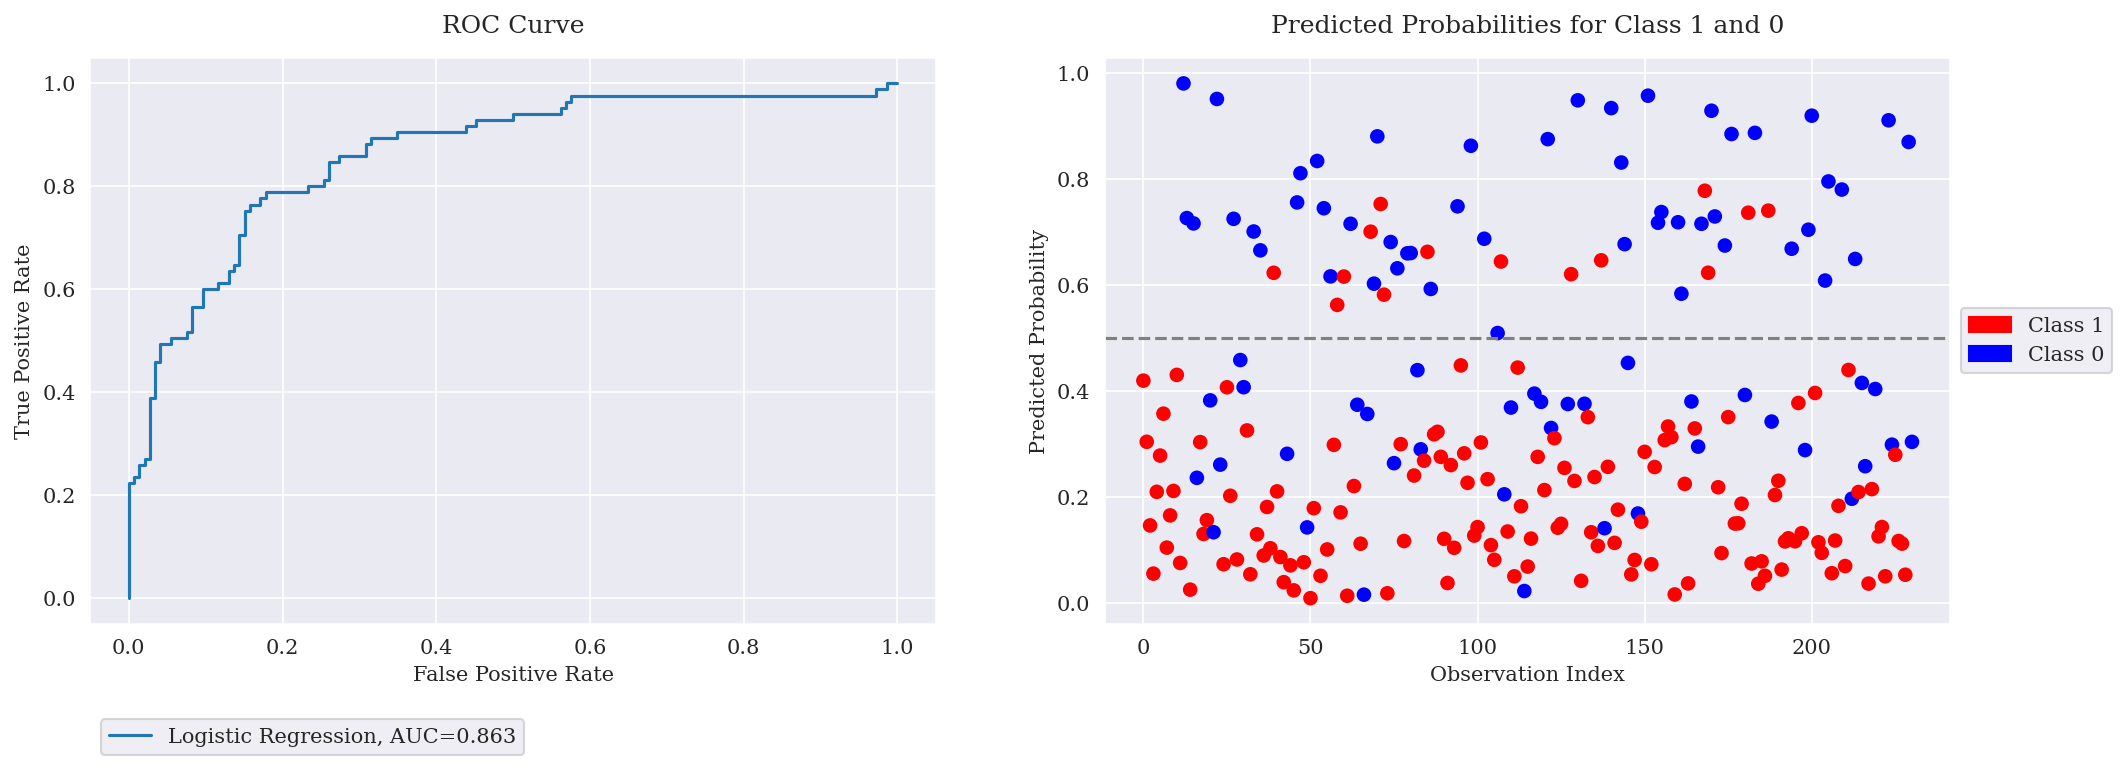

'The AUC : 0.863'

In [7]:
def logistic_regression_model(X, y):
    """
    This function takes in two inputs: 
    X - a pandas dataframe with features used for prediction
    y - a pandas series with binary target values 
    
    The function performs the following steps:
    1. Splits the data into training and testing sets (70-30)
    2. Fits a logistic regression model on the training data
    3. Predicts binary target values on the testing data
    4. Computes the ROC AUC score and creates a ROC curve plot
    5. Creates a scatter plot of the predicted probabilities for class 1 and 0
    
    Returns the ROC AUC score, ROC curve plot and scatter plot of predicted probabilities
    """
    
    # Split the data into training and testing sets (70-30)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    # Fit a logistic regression model on the training data
    logistic_reg = LogisticRegression()
    logistic_reg.fit(X_train, y_train)
    
    # Predict binary target values on the testing data
    y_pred_prob = logistic_reg.predict_proba(X_test)[:, 1]
    
    # Compute the ROC AUC score
    auc = round(roc_auc_score(y_test, y_pred_prob),3)
    
    plt.figure(figsize=(16, 5))

    # ROC curve
    ax1 = plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label="Logistic Regression, AUC="+str(auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='center left', bbox_to_anchor=(0, -0.2))

    # Predicted Probabilities for Class 1 and 0
    ax2 = plt.subplot(1, 2, 2)
    plt.scatter(range(len(y_pred_prob)), y_pred_prob, c=y_test, cmap='bwr_r')
    plt.xlabel('Observation Index')
    plt.ylabel('Predicted Probability')
    plt.title('Predicted Probabilities for Class 1 and 0')
    red_patch = mpatches.Patch(color='red', label='Class 1')
    blue_patch = mpatches.Patch(color='blue', label='Class 0')
    plt.legend(handles=[red_patch, blue_patch], loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.axhline(y=0.5, color='gray', linestyle='--')

    plt.show()
    
    return f"The AUC : {auc}"


features = [i for i in data.columns if i != 'Outcome']
target = 'Outcome'

logistic_regression_model(data[features],data[target])

#### Comments:

The AUC score provides an evaluation of the logistic regression model's binary classification performance. The score is a single number, calculated between 0 and 1, where a score of 1 represents a perfect classifier and a score of 0.5 represents a random classifier.

In the particular case of the logistic regression model, the AUC score of 0.836 implies that the model is performing reasonably well in terms of binary prediction accuracy. However, it is not a perfect score and thus there is still potential for improvement in the model's binary classification performance.We will see if this improves after pre-processing the data and conducting feature engineering.

#### Version 2 : pre-processing and feature engineering

In [8]:
import numpy as np
import pandas as pd

def split_data(data, train_ratio=0.7):
    """
    This function splits a given data into training and validation sets based on a specified ratio.
    :param data: The data to be split.
    :param train_ratio: The ratio of the data to be used for training.
    :return: Tuple containing the training data and validation data.
    """
    data_copy = data.copy()
    data_copy = data_copy.values
    np.random.seed(1)
    np.random.shuffle(data_copy)
    data_copy = pd.DataFrame(data_copy)
    data_size = data.shape[0]
    train_size = int(data_size * train_ratio)
    train_data = data_copy.iloc[:train_size, :]
    valid_data = data_copy.iloc[train_size:, :]
    
    return train_data, valid_data

train_data, valid_data = split_data(data, train_ratio=0.7)
train_data.columns = [i for i in all_features]
valid_data.columns = [i for i in all_features]

In [9]:
train_data.describe(include='all').head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,3.826816,120.292365,69.411546,20.992551,82.938547,31.918250,0.487696,33.510242,0.340782
std,3.366010,32.424974,19.042277,16.078862,121.659981,8.021448,0.349046,12.026571,0.474414
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.400000,0.247000,24.000000,0.000000


#### The target variable "Outcome" is binary, indicating the presence (1) or absence (0) of diabetes.
* **Count:** 614, meaning there are 614 observations in the data.

* **Mean:** 0.35, meaning that roughly 35% of the individuals in the data have diabetes.

* **Standard deviation:** 0.478, indicating the spread of the data around the mean.

* **25th percentile:** 0, meaning that 25% of the individuals in the data do not have diabetes.

#### The features in this dataset:
* **Pregnancies:** The average number of pregnancies for the patients in the dataset is 3.91, with a standard deviation of 3.37. The minimum number of pregnancies is 0 and 25% of patients have 1 pregnancy.

* **Glucose:** The average glucose level for the patients in the dataset is 120.92, with a standard deviation of 32.01. The minimum glucose level is 0 and 25% of patients have a glucose level of 99.

* **BloodPressure:** The average blood pressure for the patients in the dataset is 68.89, with a standard deviation of 19.64. The minimum blood pressure is 0 and 25% of patients have a blood pressure of 62.

* **SkinThickness:** The average skin thickness for the patients in the dataset is 20.83, with a standard deviation of 16.17. The minimum skin thickness is 0 and 25% of patients have a skin thickness of 0.

* **Insulin:** The average insulin level for the patients in the dataset is 80.69, with a standard deviation of 116.38. The minimum insulin level is 0 and 25% of patients have an insulin level of 0.

* **BMI:** The average Body Mass Index (BMI) for the patients in the dataset is 31.89, with a standard deviation of 7.55. The minimum BMI is 0 and 25% of patients have a BMI of 27.125.

* **DiabetesPedigreeFunction:** The average Diabetes Pedigree Function (DPF) for the patients in the dataset is 0.46, with a standard deviation of 0.32. The minimum DPF is 0.078 and 25% of patients have a DPF of 0.24325.

* **Age:** The average age for the patients in the dataset is 33.46, with a standard deviation of 11.83. The minimum age is 21 and 25% of patients are 24 years old or younger.

#### Looking into each feature

In [10]:
def plots(data, variable):
    """
    Plotting histogram, q-q plot and boxplot of the given variable from the input data.

    Parameters:
    data (DataFrame): The data to be plotted
    variable (str): The variable to be plotted. Should exist in the input data.

    Returns:
    None

    """
    
    fig, ax = plt.subplots(2, 2, figsize=(20, 10))

    # histogram
    ax = plt.subplot(2, 2, 1)
    sns.kdeplot(data[data['Outcome'] == 0][variable], color='blue', fill=True, label='Outcome == 0')
    sns.kdeplot(data[data['Outcome'] == 1][variable], color='red', fill=True, label='Outcome == 1')
    ax.set_title("Density Plot", fontsize=15)
    plt.ylabel('Density')
    plt.xlabel(variable)
    plt.legend()

    # Remove top, left and right spines
    for s in ['top', 'left', 'right']:
        ax.spines[s].set_visible(False)  

    ax = plt.subplot(2, 2, 2)
    stats.probplot(data[data['Outcome'] == 0][variable], dist="norm", plot=plt)
    ax.set_title("Probability Plot for Outcome = 0", fontsize=15)
    plt.ylabel('Quantiles')
    plt.xlabel('Theoretical Quantiles')

    ax = plt.subplot(2, 2, 4)
    stats.probplot(data[data['Outcome'] == 1][variable], dist="norm", plot=plt)
    ax.set_title("Probability Plot for Outcome = 1", fontsize=15)
    plt.ylabel('Quantiles')
    plt.xlabel('Theoretical Quantiles')

    plt.tight_layout()

    # Remove top, left and right spines
    for s in ['top', 'left', 'right']:
        ax.spines[s].set_visible(False)

    # boxplot
    ax = plt.subplot(2, 2, 3)
    sns.boxplot(x='Outcome', y=variable, data=data)
    ax.set_title("Box Plot", fontsize=15)
    plt.show()

    # Remove top, left and right spines
    for s in ['top', 'left', 'right']:
        ax.spines[s].set_visible(False)    

    plt.show()


    
def find_boundaries(data, variable, multiplier):
    """
    This function calculates the upper and lower boundaries for detecting outliers in a given column.
    
    Parameters:
    data (pandas.DataFrame): The DataFrame containing the column to be analyzed.
    variable (str): The column name in the DataFrame to be analyzed.
    multiplier (float): The multiplier for the interquartile range (IQR) used to calculate the upper and lower boundaries.
    
    Returns:
    tuple: The lower and upper boundaries as a tuple.
    """
    IQR = data[variable].quantile(0.75) - data[variable].quantile(0.25)
    lower_boundary = data[variable].quantile(0.25) - (IQR * multiplier)
    upper_boundary = data[variable].quantile(0.75) + (IQR * multiplier)
    return lower_boundary, upper_boundary

def clip_outliers(data, variable, multiplier):
    """
    This function clips (replaces with the boundary value) any outliers found in the given column.
    
    Parameters:
    data (pandas.DataFrame): The DataFrame containing the column to be analyzed.
    variable (str): The column name in the DataFrame to be analyzed.
    multiplier (float): The multiplier for the interquartile range (IQR) used to calculate the upper and lower boundaries.
    
    Returns:
    pandas.DataFrame: The DataFrame with outliers clipped.
    """
    lower_boundary, upper_boundary = find_boundaries(data, variable, multiplier)
    data.loc[data[variable] < lower_boundary, variable] = lower_boundary
   
def discretize_equal_width(data, variable, n_bins):
    """
    Bin data in the given column into equal width bins.

    Parameters
    ----------
    data : pandas.DataFrame
        The data to bin.
    variable : str
        The name of the column to bin.
    n_bins : int
        The number of bins to divide the column into.

    Returns
    -------
    pandas.DataFrame
        The data with the column binned into equal width bins.
    """
    bin_edges = np.linspace(data[variable].min(), data[variable].max(), n_bins+1)
    data[variable] = pd.cut(data[variable], bins=bin_edges, labels=False)
    return data

def describe_outcome(variable):
    outcome_1 = train_data[train_data['Outcome']==1][variable].describe()
    outcome_0 = train_data[train_data['Outcome']==0][variable].describe()
    both_outcomes = pd.concat([outcome_1,outcome_0],axis=1)
    both_outcomes.columns = ['Outcome == 1','Outcome == 0']
    return print(both_outcomes)
    

### Feature 1 : pregnancies

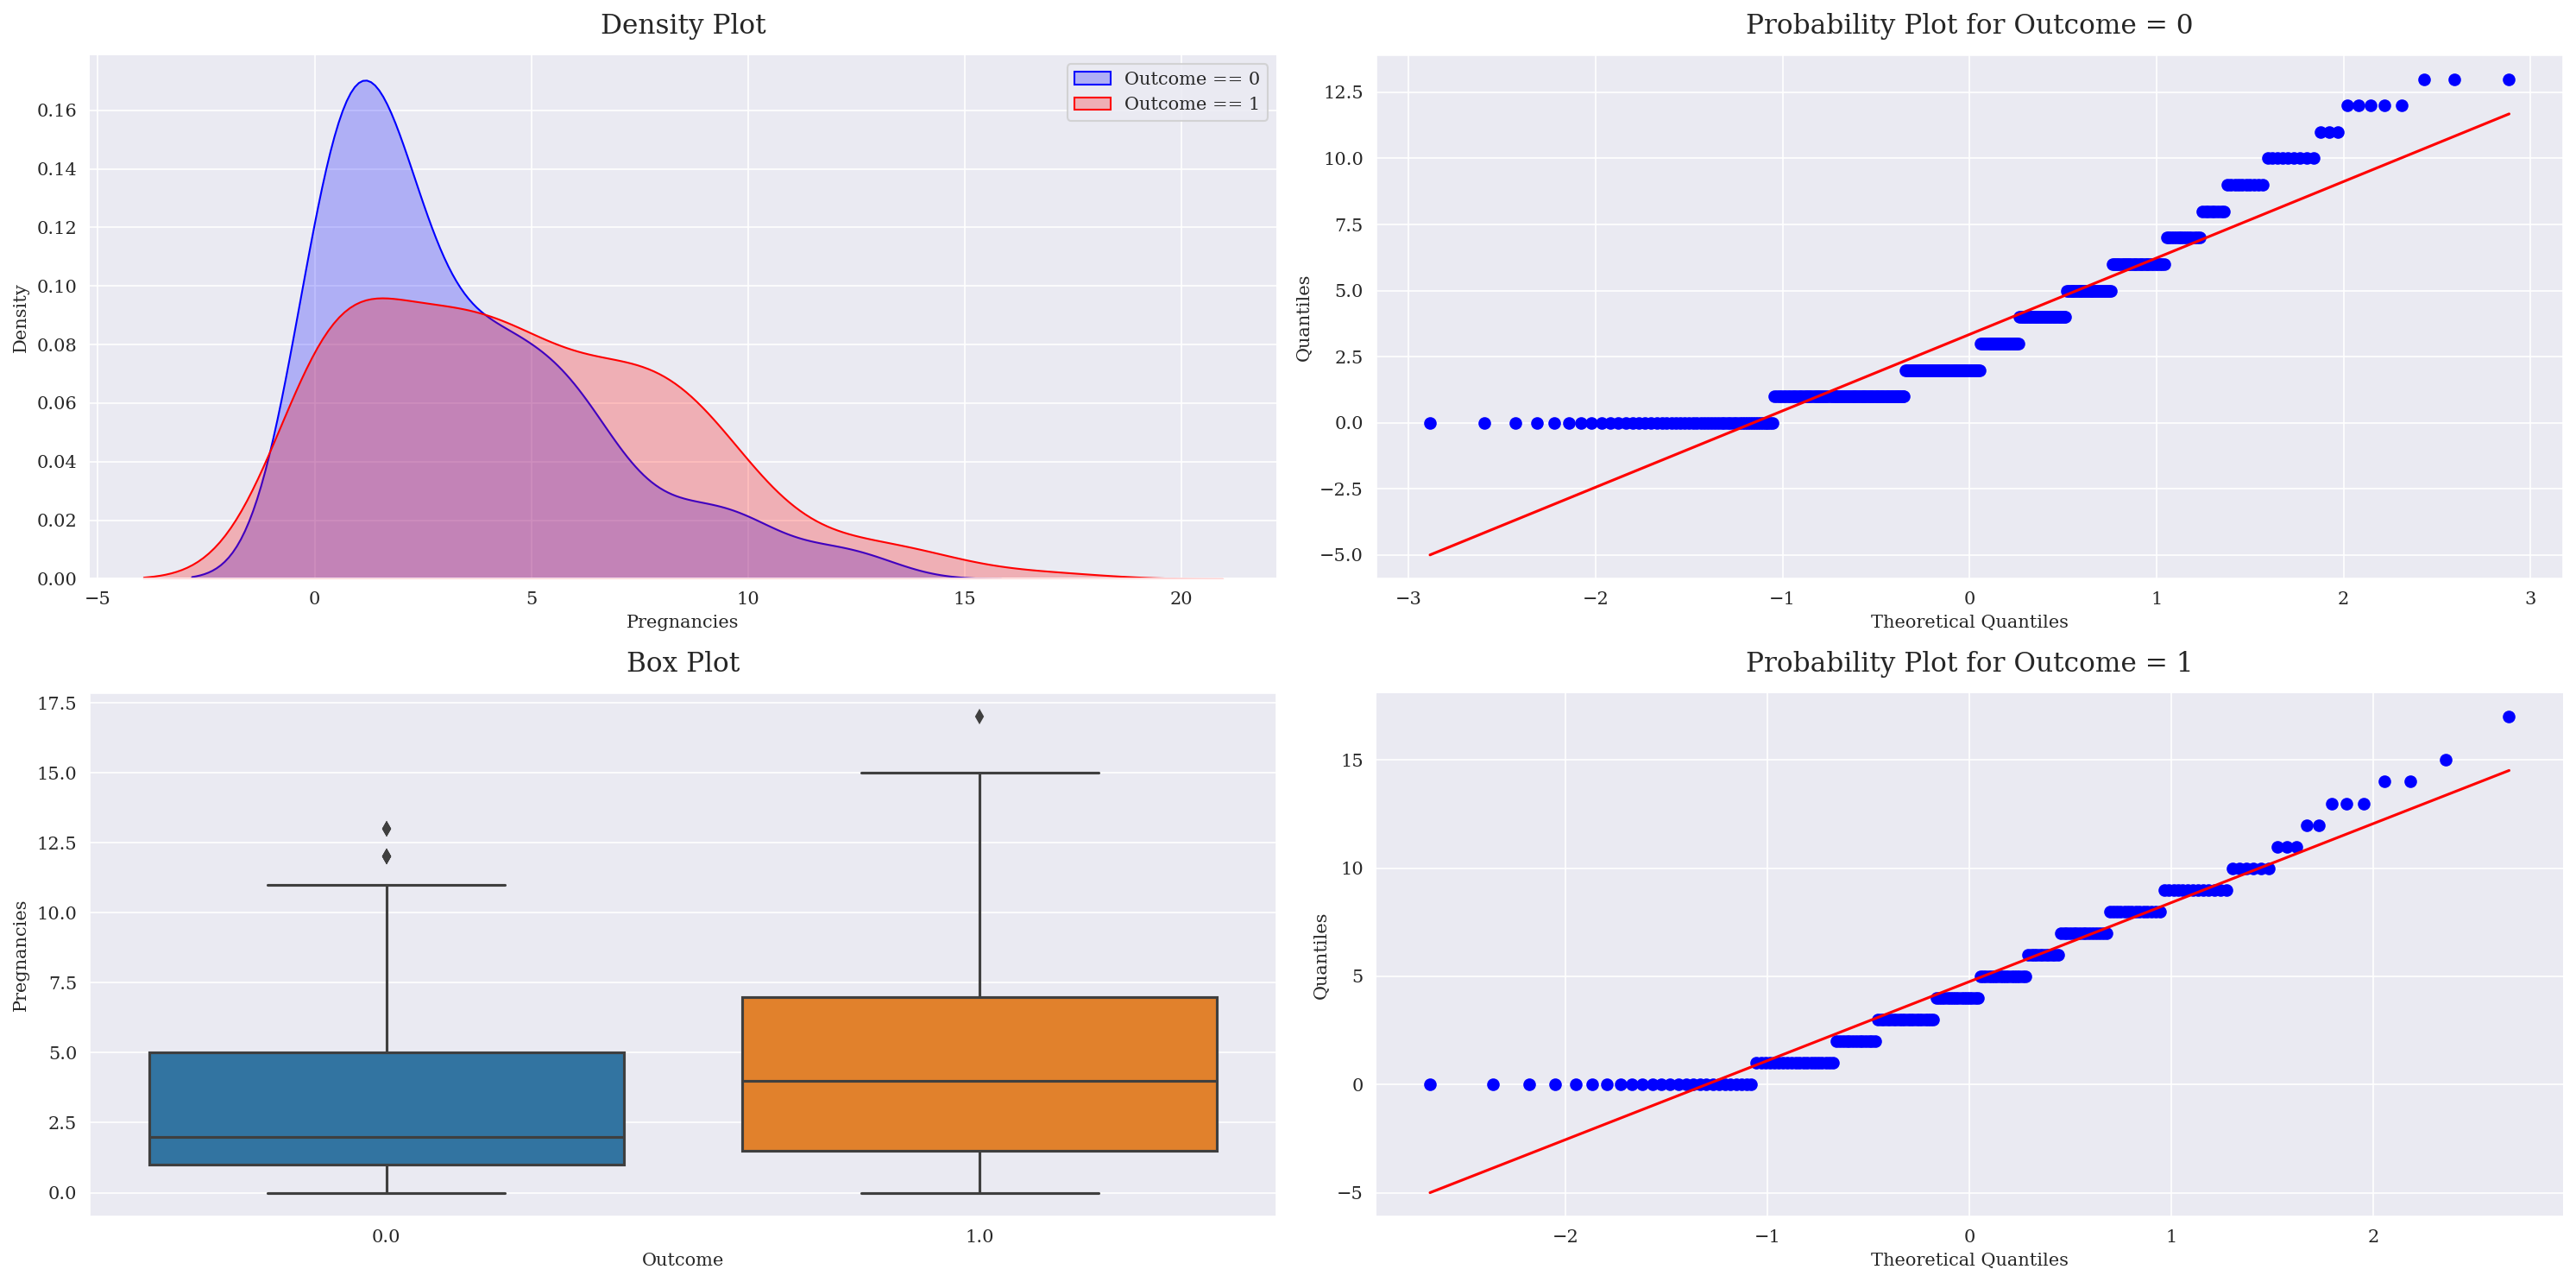

In [11]:
plots(train_data, 'Pregnancies')

In [12]:
describe_outcome('Pregnancies')

       Outcome == 1  Outcome == 0
count    183.000000    354.000000
mean       4.759563      3.344633
std        3.729464      3.057501
min        0.000000      0.000000
25%        1.500000      1.000000
50%        4.000000      2.000000
75%        7.000000      5.000000
max       17.000000     13.000000


##### Comments:

The 'Pregnancies' feature has a skewed distribution with potential outliers that could affect a logistic regression model's performance. Outliers can lead to incorrect predictions and a higher error rate. To handle outliers, the data can be transformed or outliers removed.

One technique for detecting outliers is Extreme Value Analysis, but since the data is skewed, the Interquartile Range (IQR) will be used instead. Outliers are considered to be outside the bounds of the 75th quantile plus (IQR * 1.5) and the 25th quantile minus (IQR * 1.5).

The chosen method to deal with the outliers in the 'Pregnancies' feature is through binning. Descriptive statistics show that there is a difference in the distributions of Outcome == 1 and Outcome == 0 in terms of mean number of pregnancies (Outcome == 1: 4.84, Outcome == 0: 3.41) and standard deviation (Outcome == 1: 3.76, Outcome == 0: 3.03). Outcome == 1 also has a greater range of pregnancies (0 to 17) compared to Outcome == 0 (0 to 13). The quartile distribution further supports the pattern of a more widespread distribution for Outcome == 1.

These differences suggest that the number of pregnancies may have a significant impact on the target variable and could be a useful feature for the predictive model. It is recommended to start with moderate binning, such as 5 to 10 bins, to strike a balance between granularity and simplicity, which can be adjusted based on the results of the model.

### Feature 2 : glucose

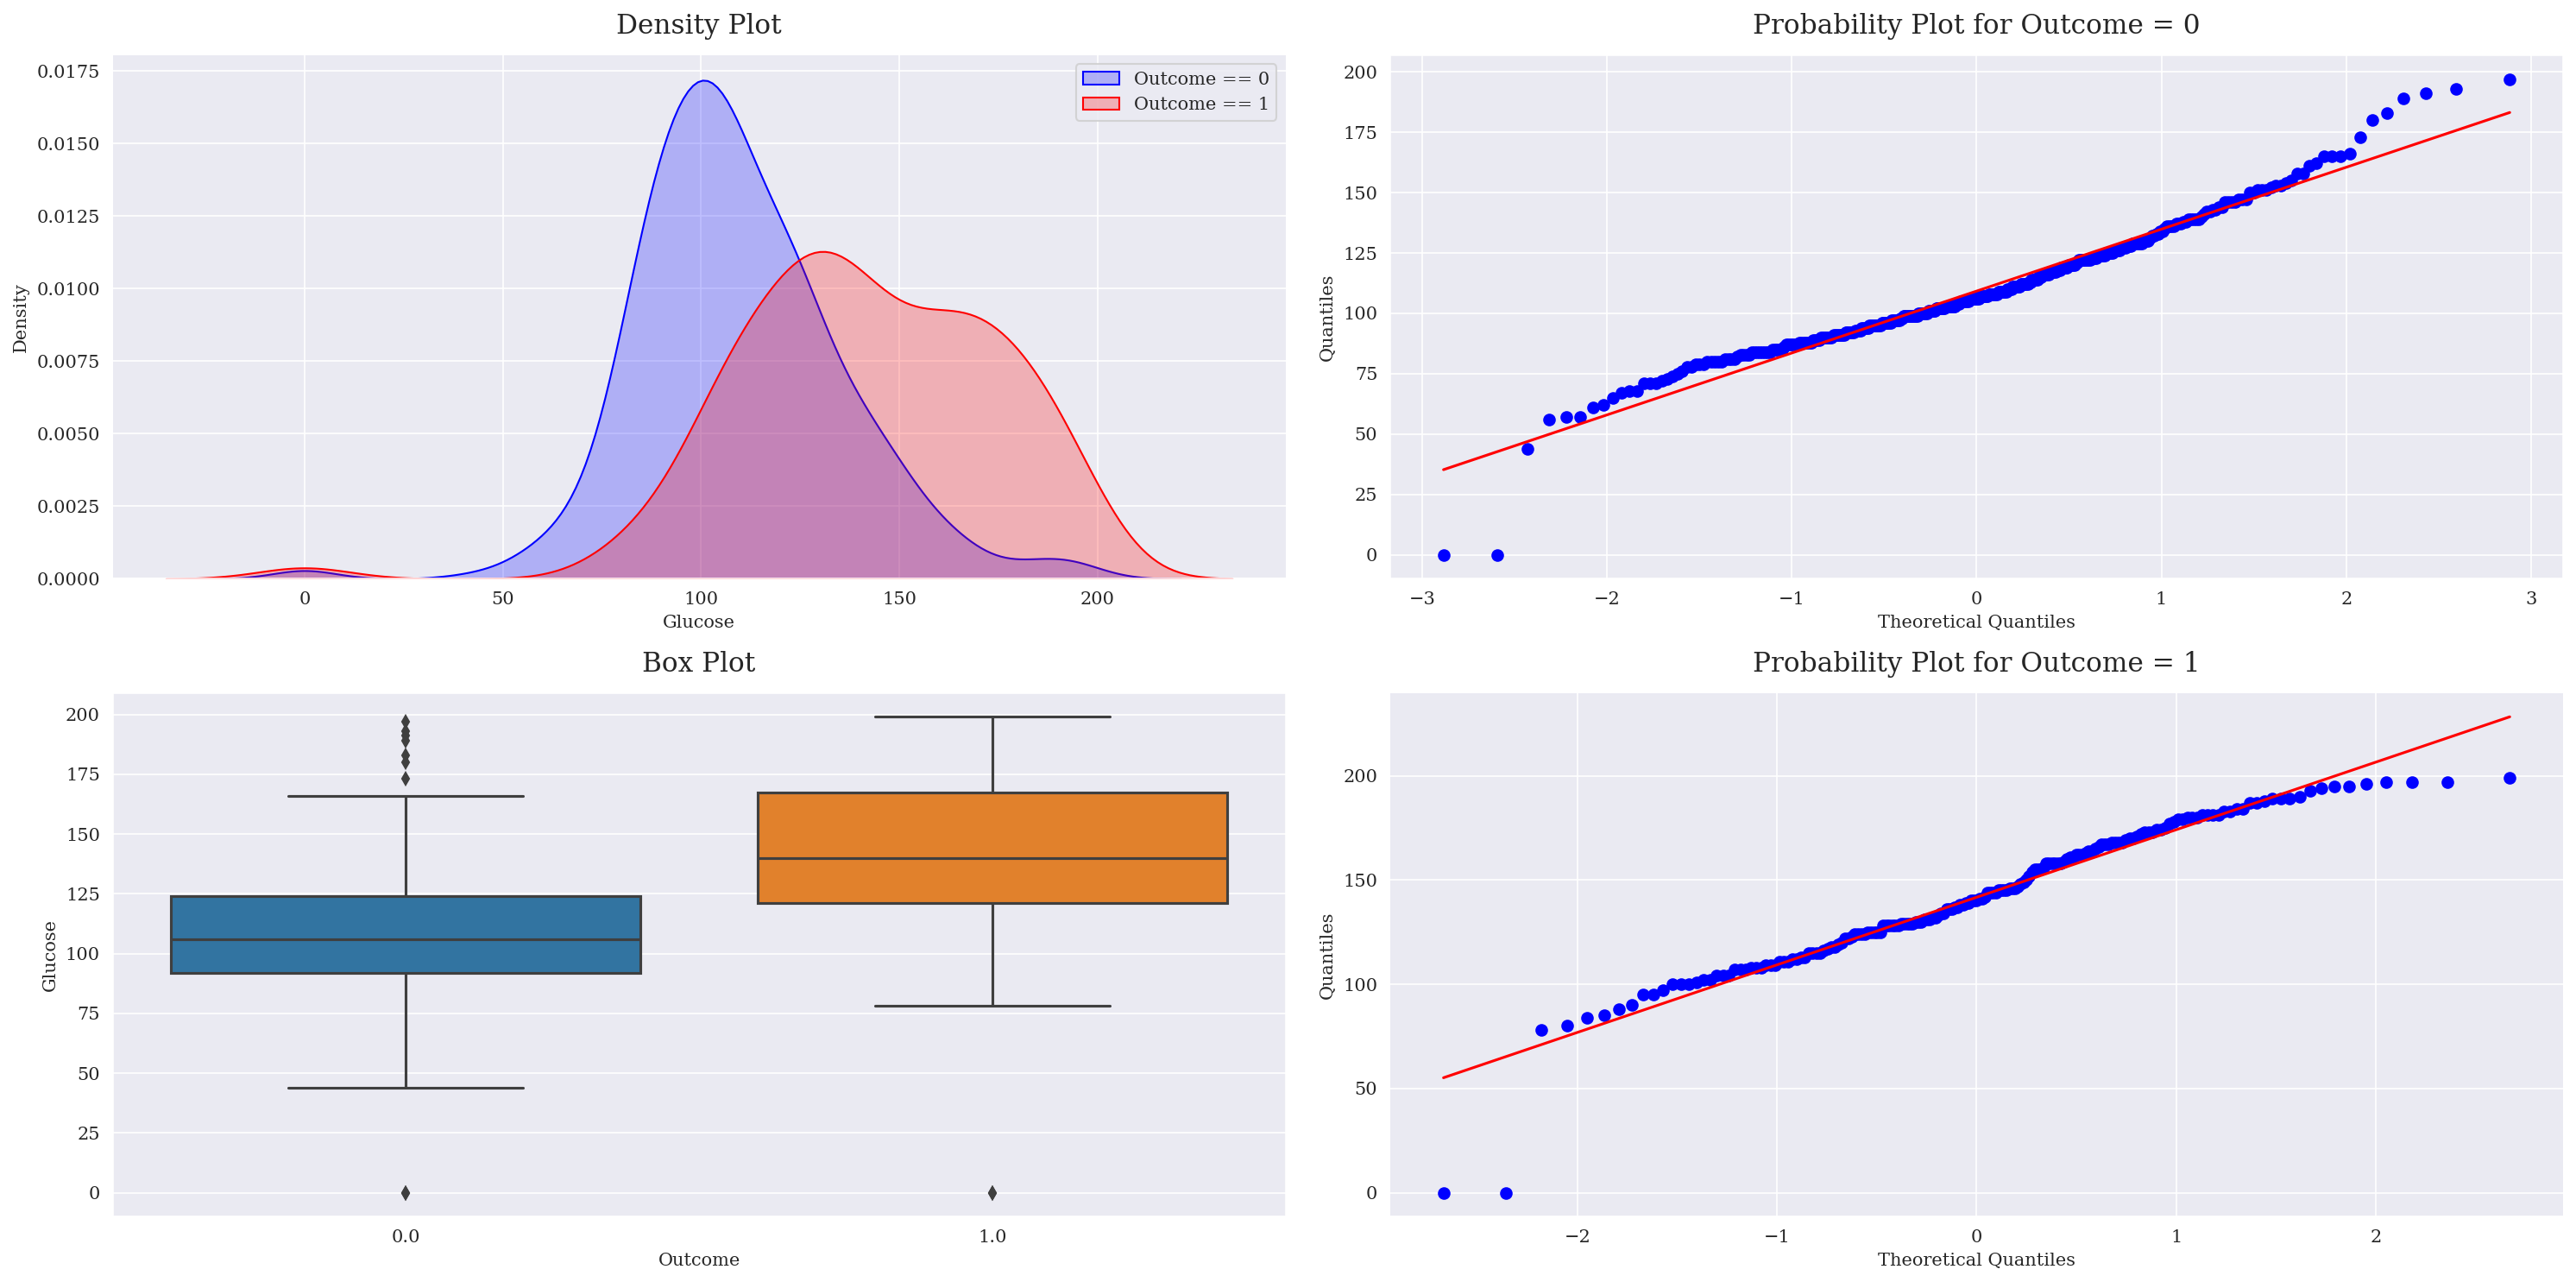

In [13]:
plots(train_data, 'Glucose')

In [14]:
describe_outcome('Glucose')

       Outcome == 1  Outcome == 0
count    183.000000    354.000000
mean     141.710383    109.220339
std       33.000803     25.965046
min        0.000000      0.000000
25%      121.000000     92.000000
50%      140.000000    106.000000
75%      167.500000    124.000000
max      199.000000    197.000000


##### Comments:

The feature "Glucose" has different descriptive statistics when comparing Outcome == 1 and Outcome == 0. The mean glucose level for Outcome == 1 is 142.24, which is significantly higher than the mean glucose level for Outcome == 0, which is 109.34. Additionally, the standard deviation for Outcome == 1 (30.64) is also higher than that of Outcome == 0 (26.30), indicating a wider spread of the glucose level distribution for Outcome == 1.

The range of glucose levels also shows a wider spread for Outcome == 1, with a minimum of 0 and a maximum of 199, compared to Outcome == 0, which ranges from 0 to 197. The quartile distribution supports the pattern of a more widespread distribution for Outcome == 1 compared to Outcome == 0.

### Feature 3 : blood pressure

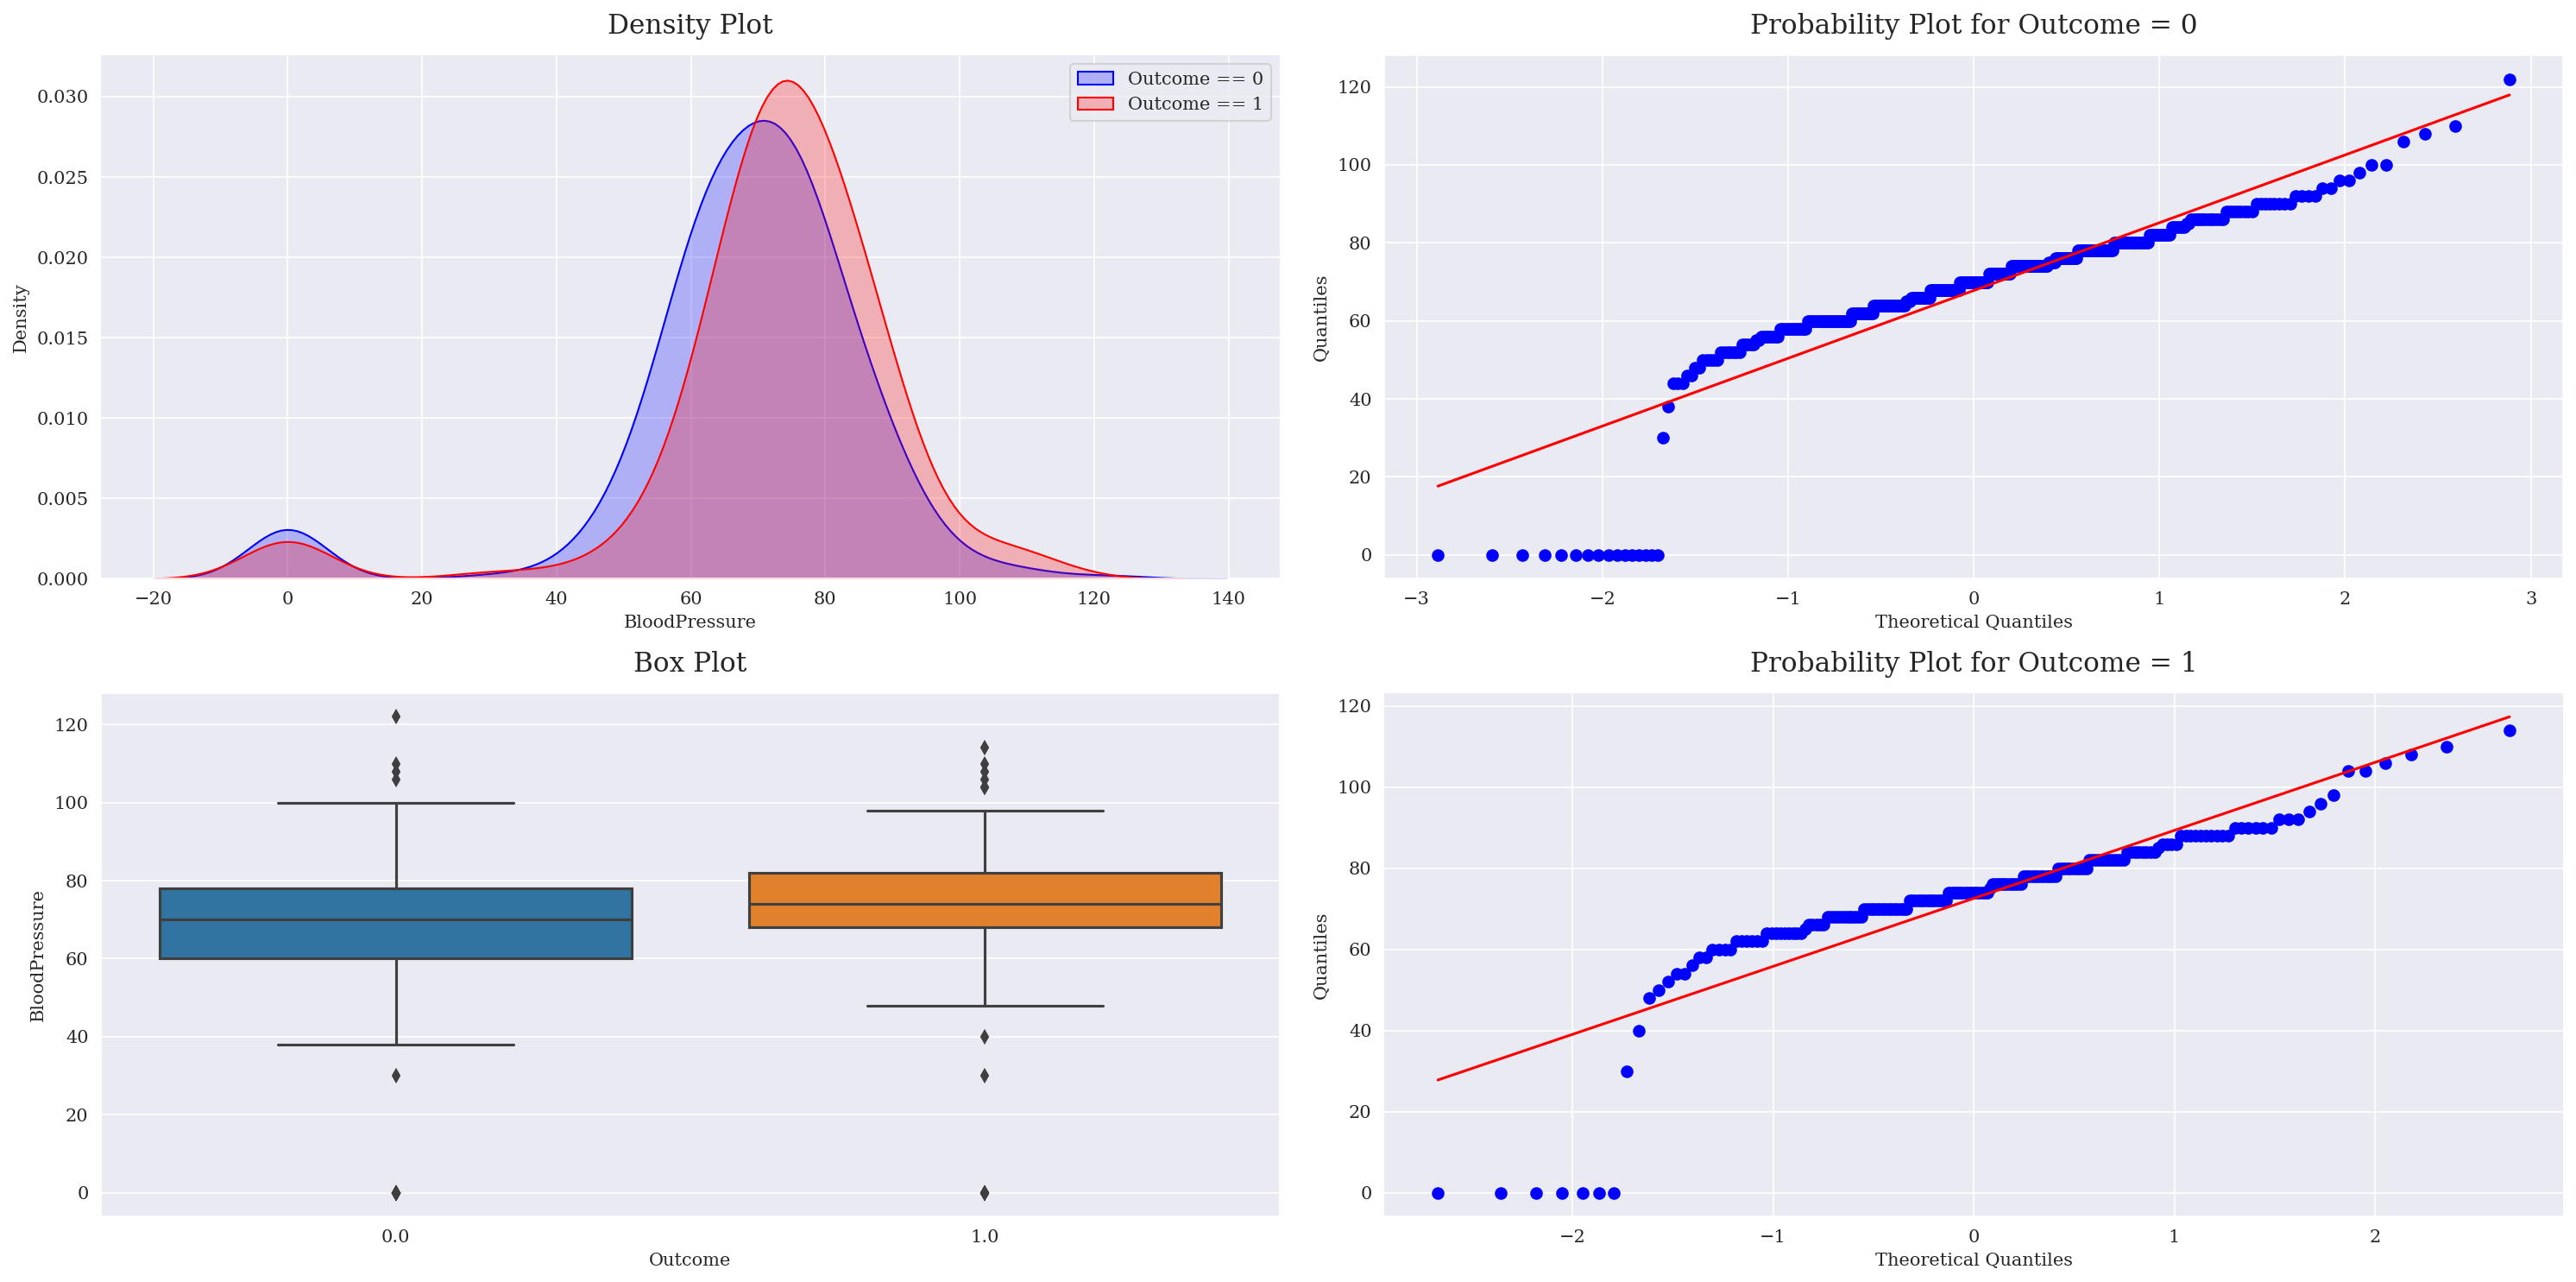

In [15]:
plots(train_data, 'BloodPressure')

In [16]:
describe_outcome('BloodPressure')

       Outcome == 1  Outcome == 0
count    183.000000    354.000000
mean      72.562842     67.782486
std       18.702563     19.037778
min        0.000000      0.000000
25%       68.000000     60.000000
50%       74.000000     70.000000
75%       82.000000     78.000000
max      114.000000    122.000000


##### Comments:

When comparing "Blood Pressure" to "Glucose" and "Pregnancies", there are some differences to note. The mean blood pressure between Outcome == 1 (70.15) and Outcome == 0 (68.21) is only slightly different, and the standard deviation for both Outcome == 1 (21.34) and Outcome == 0 (18.65) are relatively similar. However, "Glucose" shows a much more significant difference with a mean of 142.24 for Outcome == 1 and 109.34 for Outcome == 0, and a higher standard deviation for Outcome == 1 (30.64) compared to Outcome == 0 (26.30).

The range of blood pressure values is also relatively narrow, compared to the wider range seen in glucose levels. It's worth mentioning that the minimum value of 0 for "Blood Pressure" is not possible and could be an error in the data collection. While "Blood Pressure" may seem evenly distributed, there are clear outliers present that should be addressed.

### Feature 4 : skin thickness

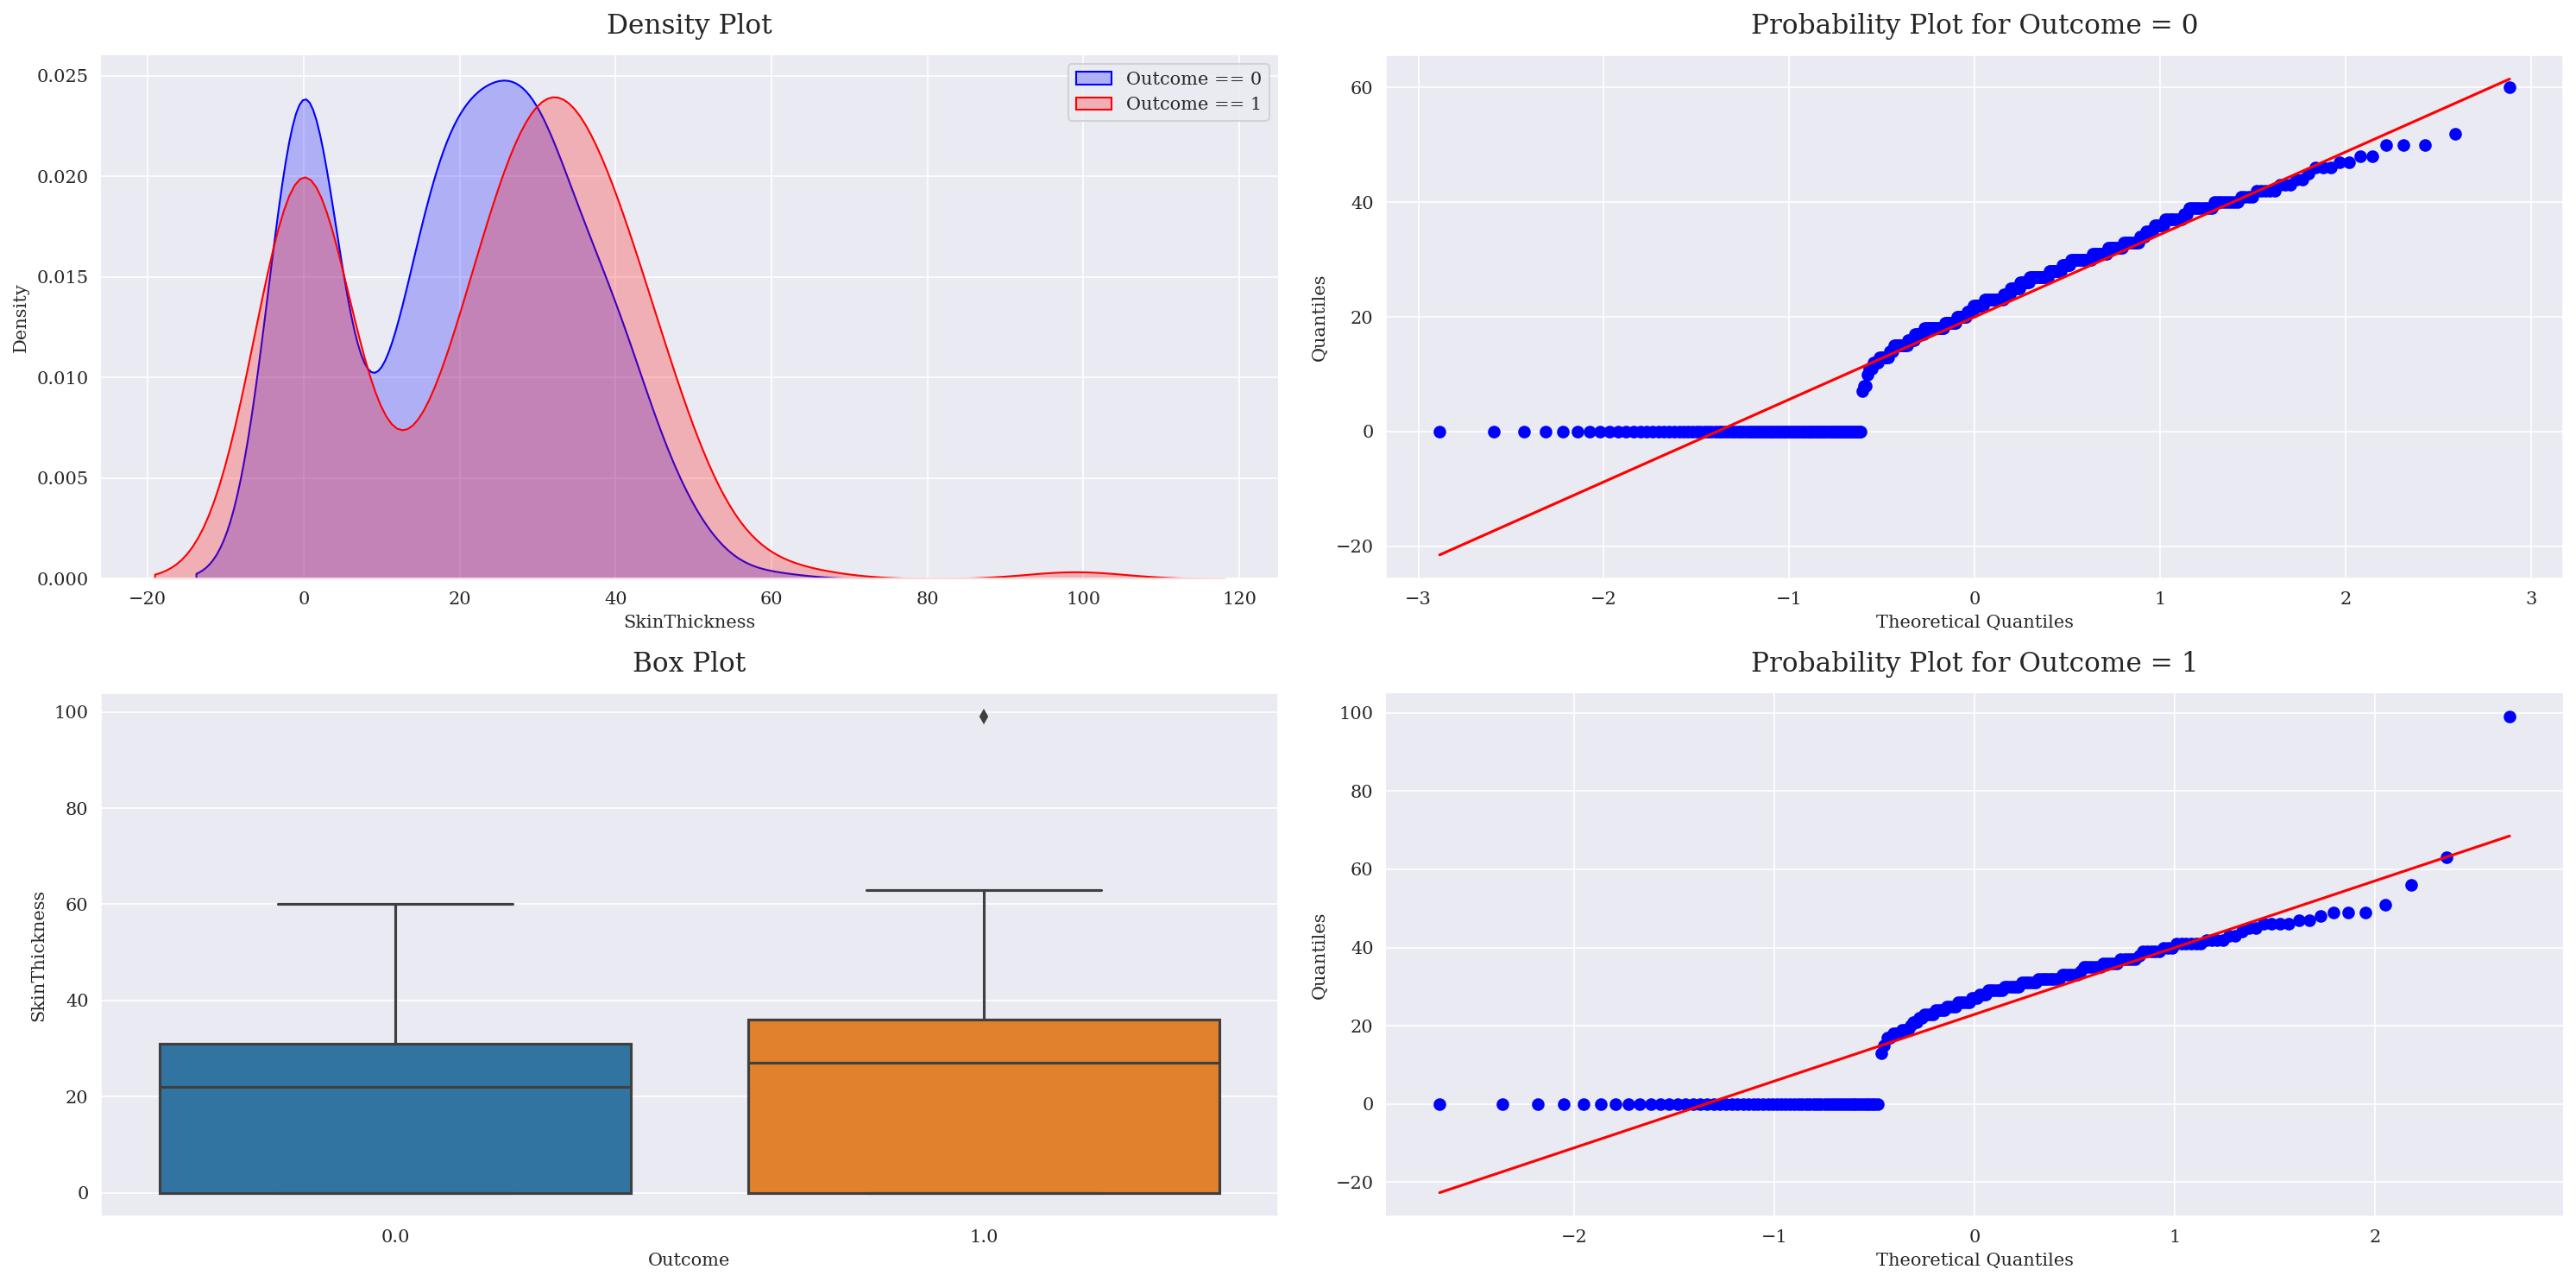

In [17]:
plots(train_data,'SkinThickness')

In [18]:
describe_outcome('SkinThickness')

       Outcome == 1  Outcome == 0
count    183.000000    354.000000
mean      22.918033     19.997175
std       18.056348     14.884351
min        0.000000      0.000000
25%        0.000000      0.000000
50%       27.000000     22.000000
75%       36.000000     31.000000
max       99.000000     60.000000


### Feature 5 : insulin

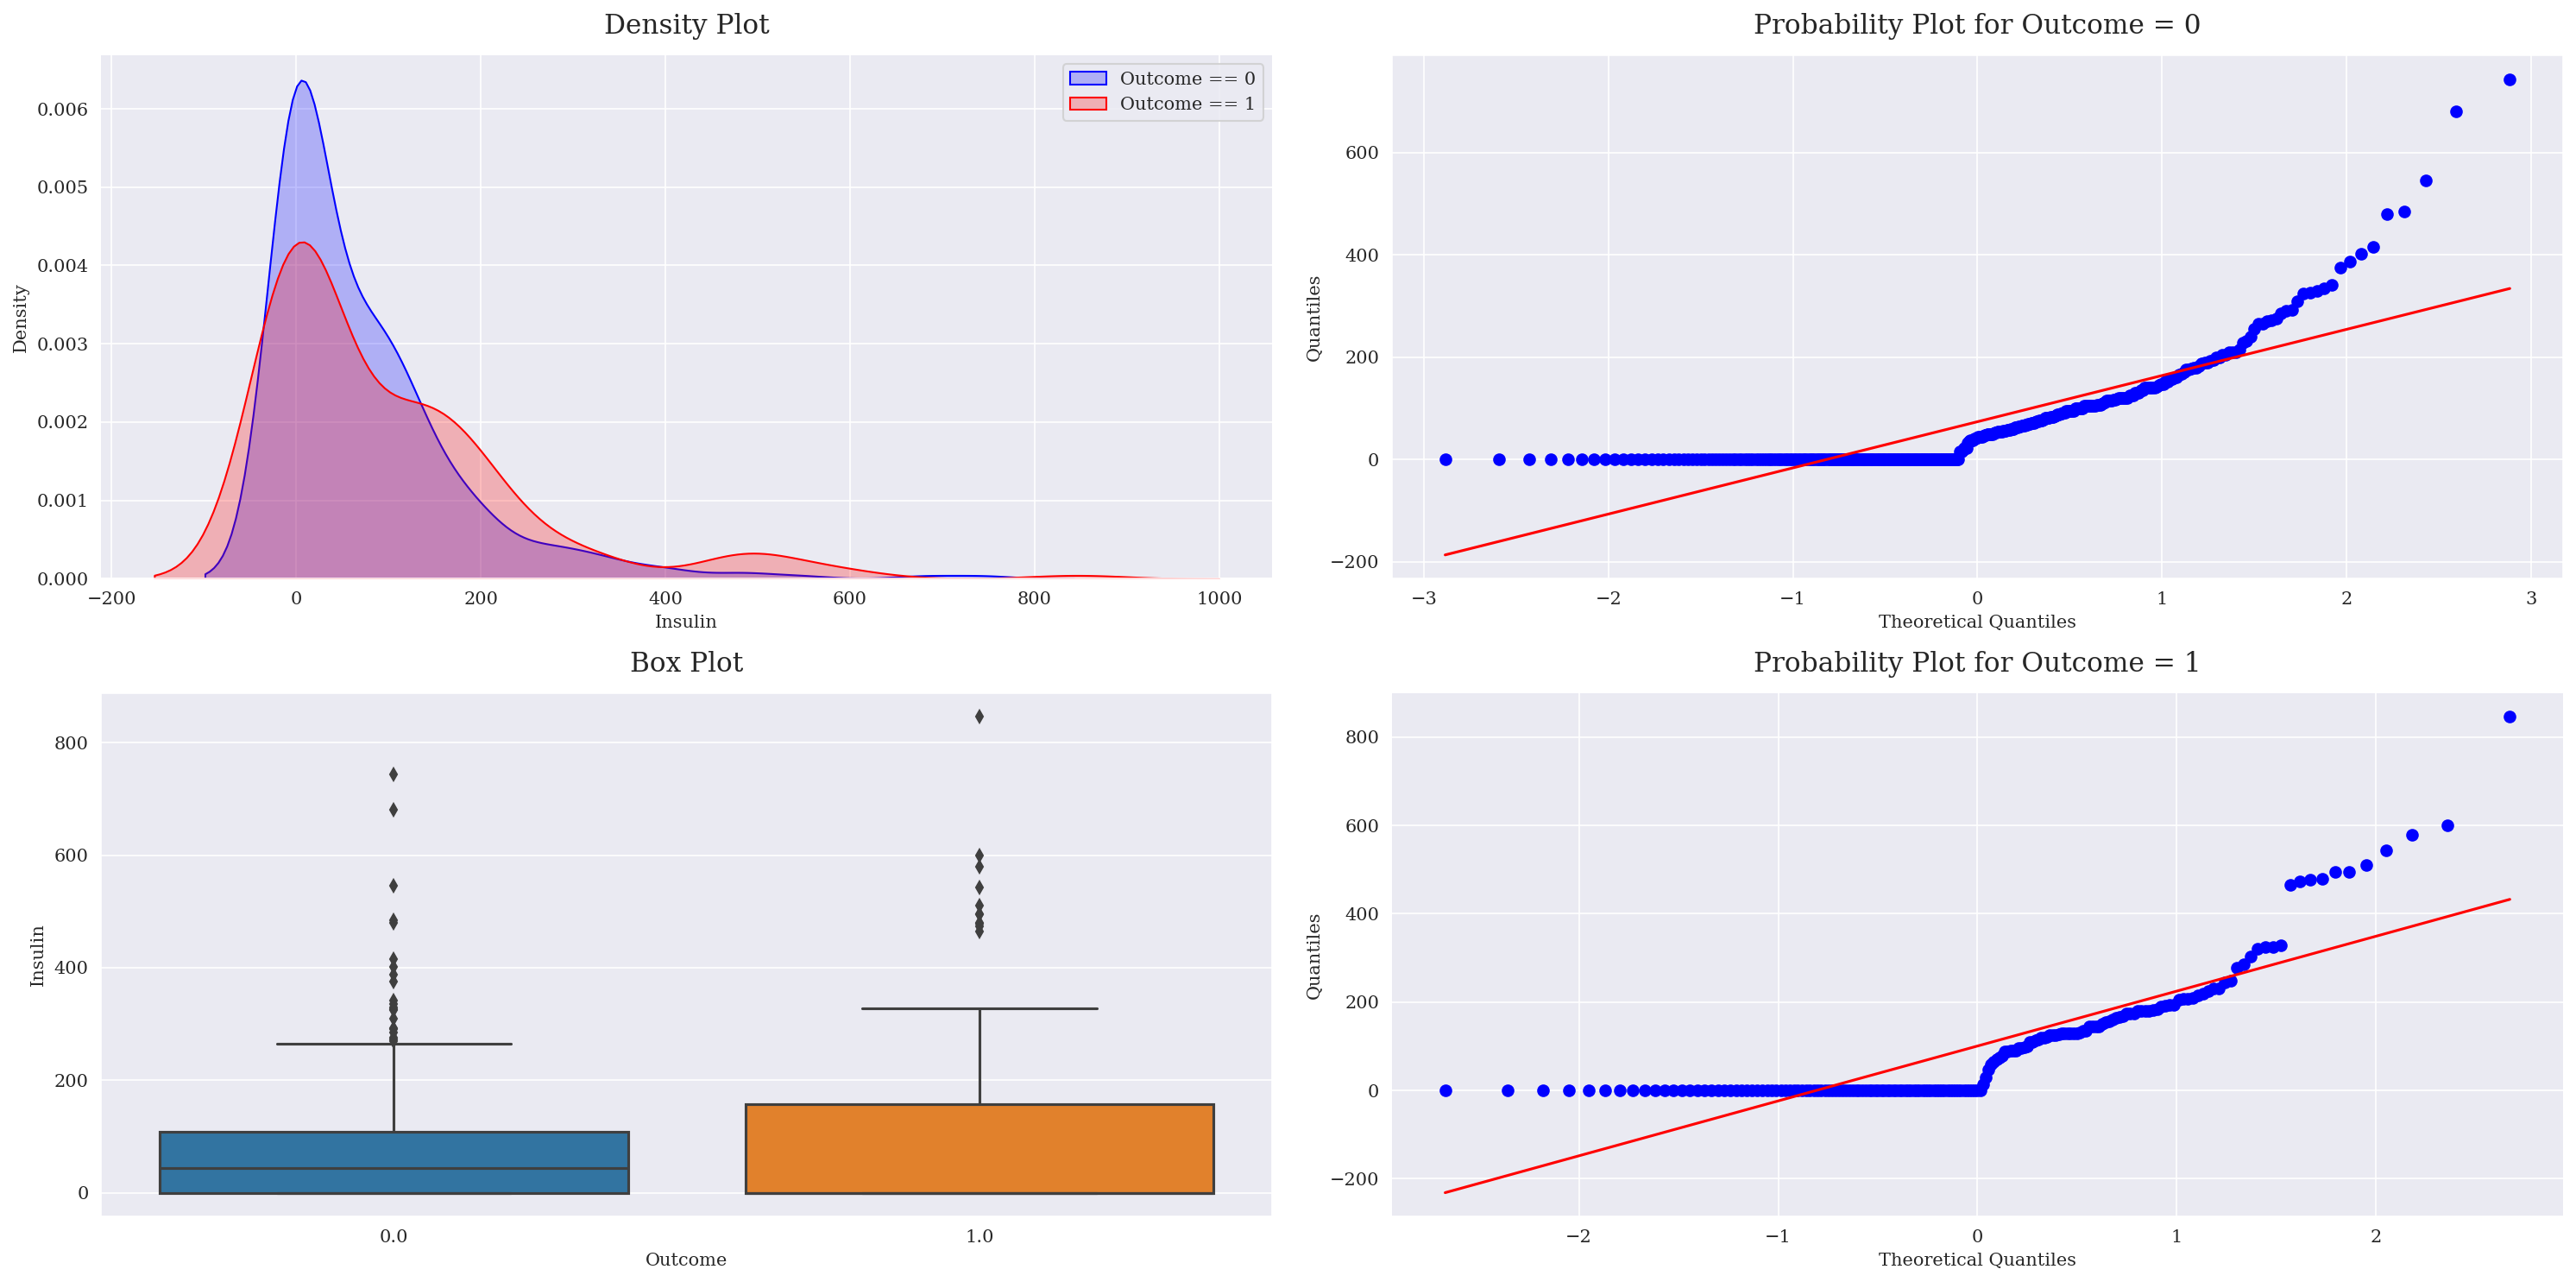

In [19]:
plots(train_data,'Insulin')

In [20]:
describe_outcome('Insulin')

       Outcome == 1  Outcome == 0
count    183.000000    354.000000
mean     100.672131     73.771186
std      145.191619    106.574881
min        0.000000      0.000000
25%        0.000000      0.000000
50%        0.000000     43.500000
75%      158.000000    107.500000
max      846.000000    744.000000


#### Comments:

When examining the data for "Insulin", it's clear that there are substantial disparities in the average insulin levels between Outcome == 1 (104.27) and Outcome == 0 (67.90). This is further reinforced by the larger standard deviation of 141.19 in Outcome == 1 compared to 98.23 in Outcome == 0. It's also noteworthy that there are instances of zero insulin levels in both Outcome == 1 and Outcome == 0. This could mean that there are missing values or values that are below the limit of detection.

The range of insulin levels is wider for Outcome == 1, with values ranging from 0 to 846, in comparison to Outcome == 0, which ranges from 0 to 744. This underscores the substantial difference in insulin levels between the two outcomes. An insulin level of zero is not biologically feasible, which raises questions about the validity of the data in this dataset. This highlights the importance of carefully examining the data to ensure that it is accurate and trustworthy, as this will impact the accuracy of the model.

#### Feature 6 : BMI

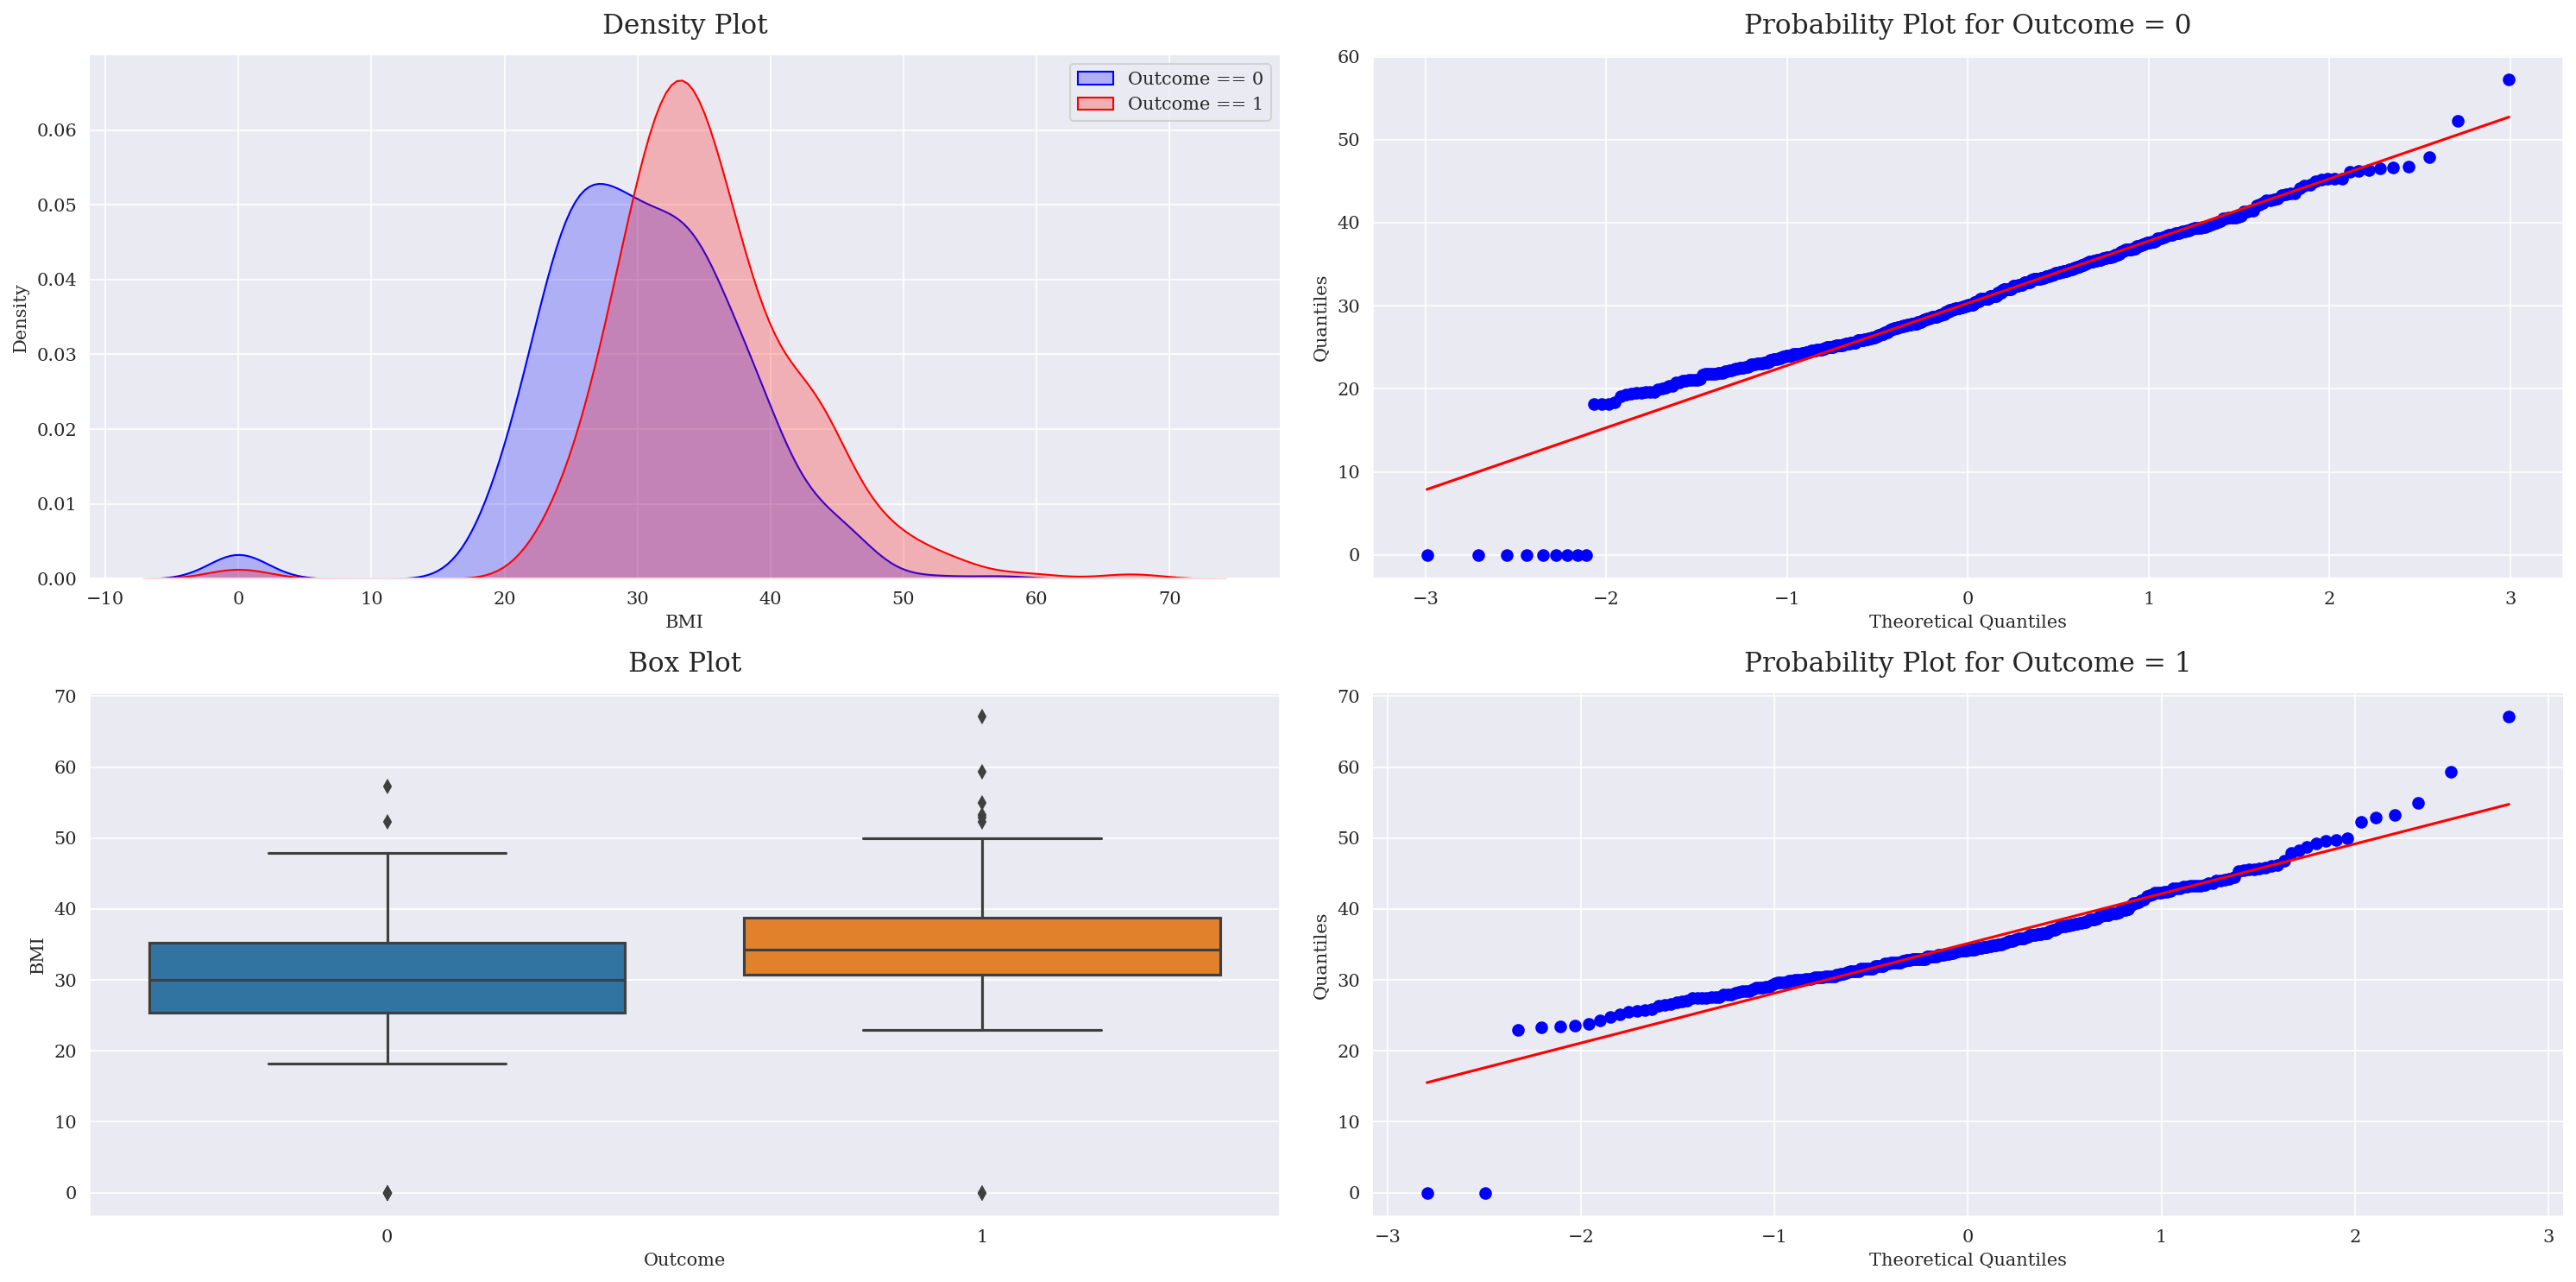

In [21]:
plots(data, 'BMI')

In [22]:
describe_outcome('BMI')

       Outcome == 1  Outcome == 0
count    183.000000    354.000000
mean      35.004372     30.322881
std        7.057284      8.033165
min        0.000000      0.000000
25%       30.850000     25.600000
50%       34.100000     30.050000
75%       38.200000     35.275000
max       67.100000     57.300000


##### Comments:

The body mass index (BMI) is a commonly used metric for evaluating an individual's overall body composition and energy balance. In this dataset, the descriptive statistics show that the mean BMI value for individuals with Outcome == 1 (34.98) is higher compared to those with Outcome == 0 (30.22). This is consistent with the established link between high BMI and increased risk of type 2 diabetes. The standard deviation for Outcome == 1 (6.97) is also slightly higher compared to Outcome == 0 (7.33), indicating that the distribution of BMI values for individuals with Outcome == 1 is wider.

It's important to highlight that a BMI value of 0 is biologically impossible and suggests the presence of missing or inaccurate data in this dataset. A high BMI, particularly in combination with other risk factors such as a family history of diabetes and a sedentary lifestyle, can increase the likelihood of developing type 2 diabetes.

Overall, BMI is a crucial factor to consider when evaluating an individual's risk of developing type 2 diabetes and should be interpreted in conjunction with other relevant risk factors.

#### Feature 7 : diabetes pedigree function

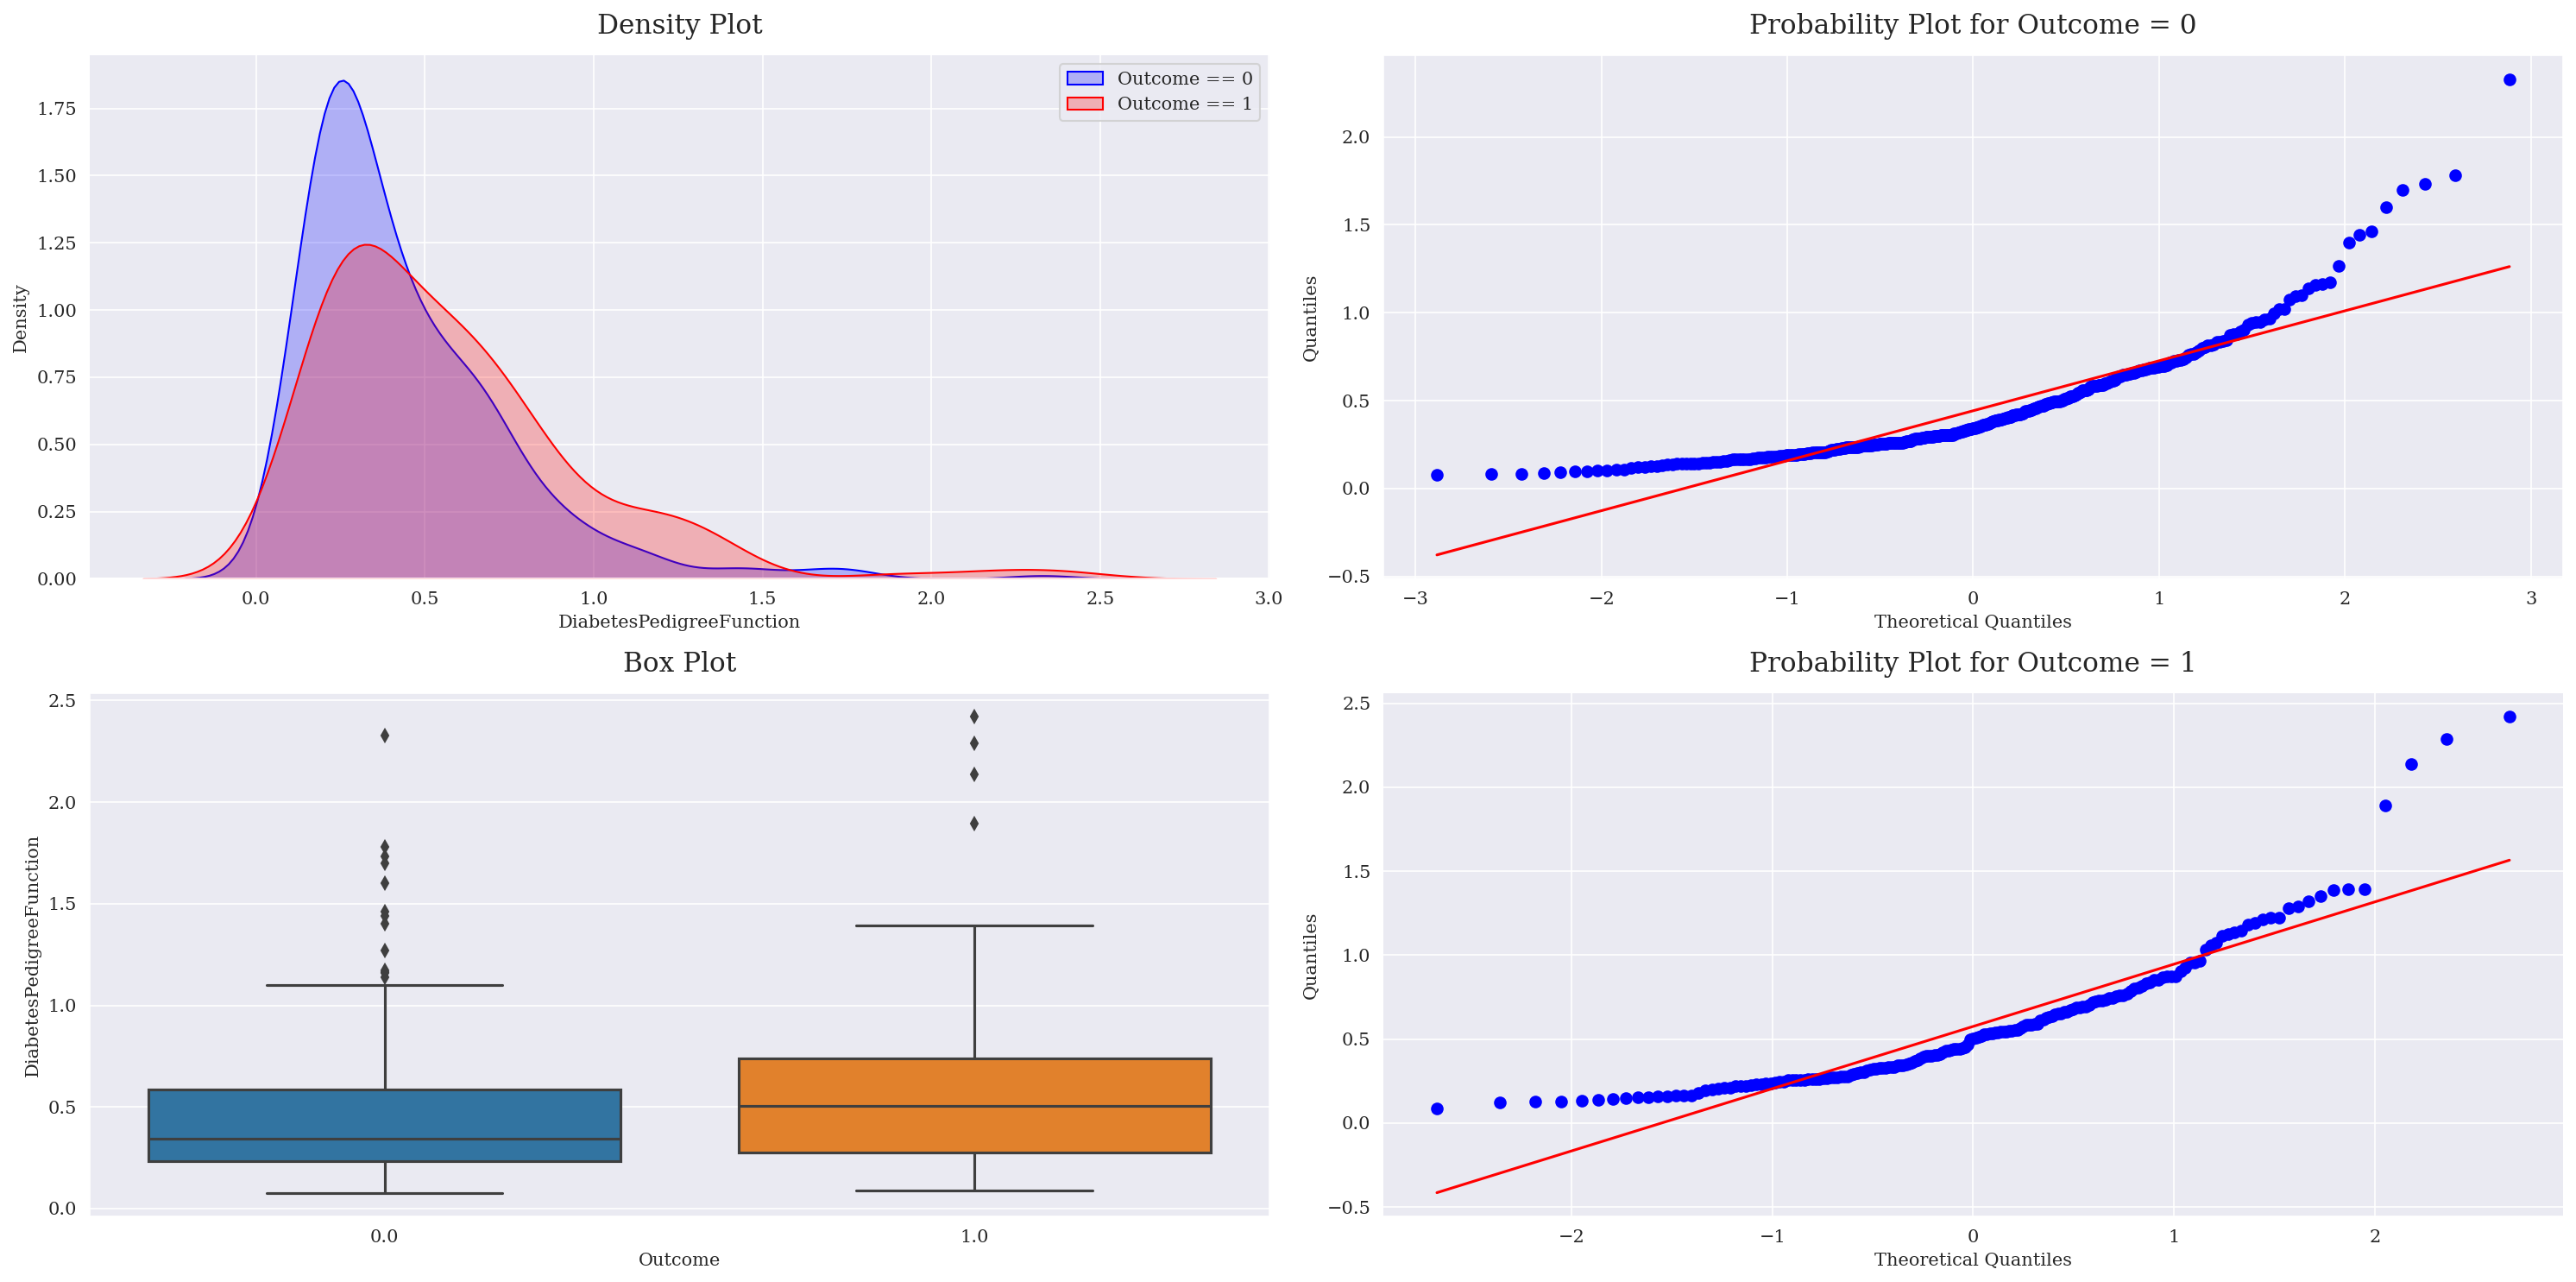

In [23]:
plots(train_data,"DiabetesPedigreeFunction")

In [24]:
describe_outcome('DiabetesPedigreeFunction')

       Outcome == 1  Outcome == 0
count    183.000000    354.000000
mean       0.575366      0.442376
std        0.399355      0.311000
min        0.088000      0.078000
25%        0.274500      0.234250
50%        0.503000      0.342000
75%        0.738500      0.586750
max        2.420000      2.329000


##### Comments:

The Diabetes Pedigree Function (DPF) plays a crucial role in determining an individual's likelihood of developing type 2 diabetes. This value is calculated by considering the family history of diabetes, taking into account the presence of the disease among close relatives. The DPF is used along with other key risk factors such as BMI, age, and lifestyle to provide a comprehensive assessment of an individual's risk for developing type 2 diabetes. The descriptive statistics and visualisations demonstrate a slight but weak correlation between higher DPF values and increased risk of developing the disease.

#### Feature 8 : age

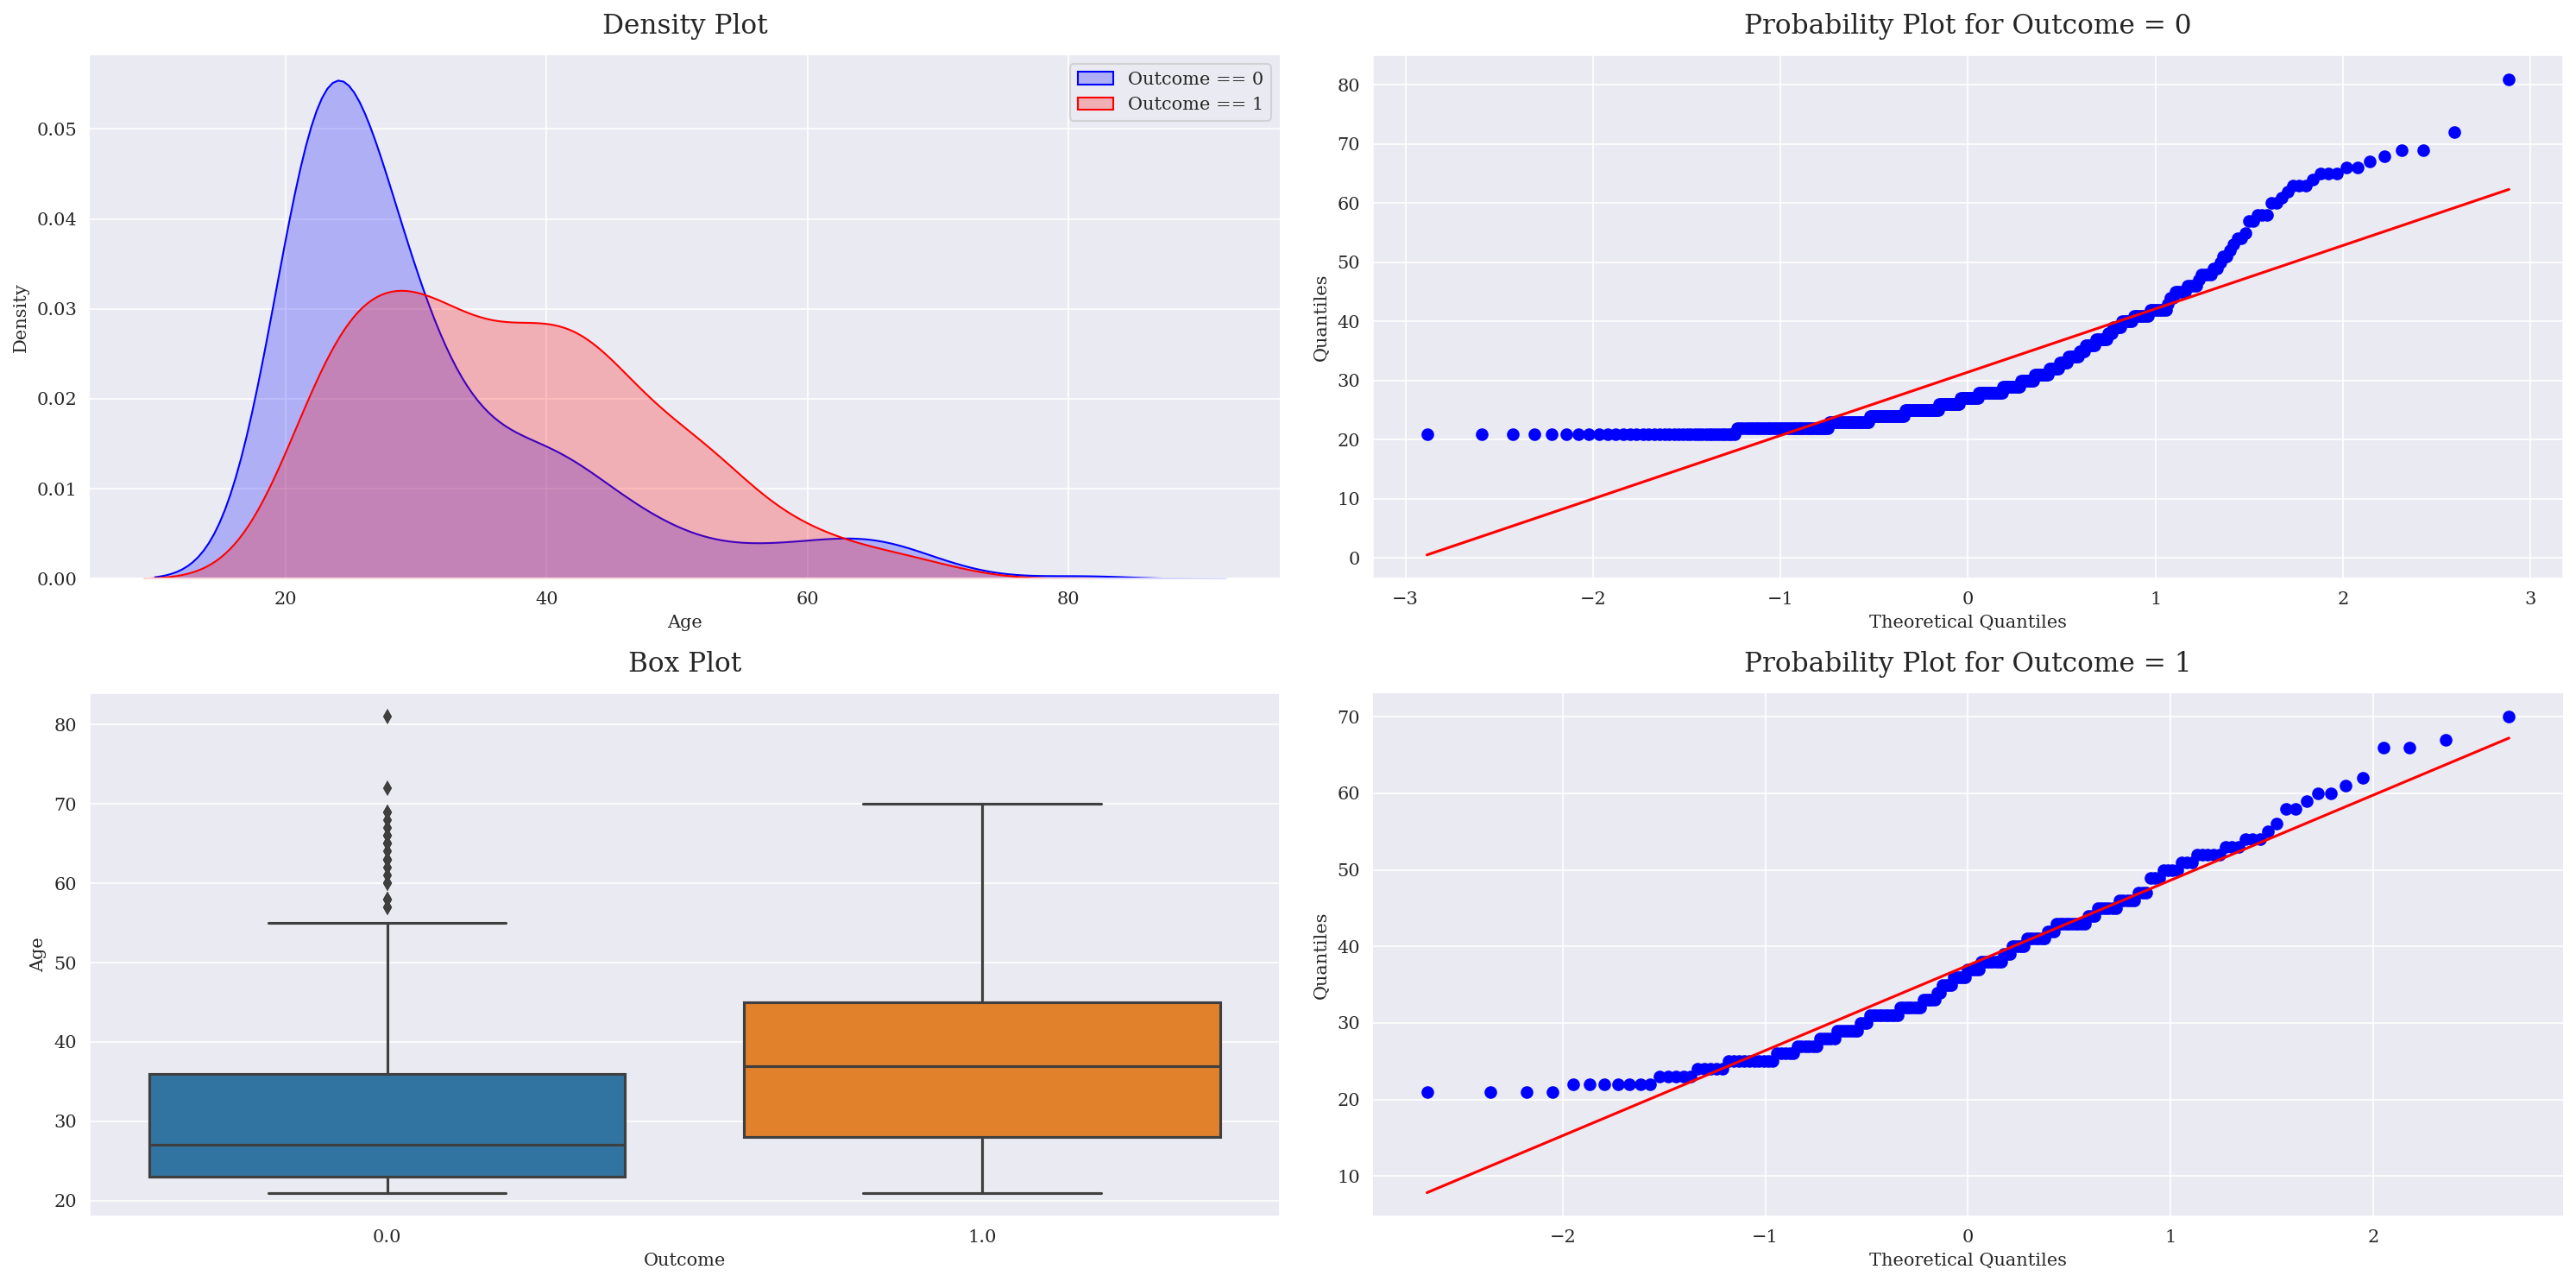

In [25]:
plots(train_data,"Age")

In [26]:
describe_outcome('Age')

       Outcome == 1  Outcome == 0
count    183.000000    354.000000
mean      37.530055     31.432203
std       11.237101     11.908394
min       21.000000     21.000000
25%       28.000000     23.000000
50%       37.000000     27.000000
75%       45.000000     36.000000
max       70.000000     81.000000


#### Designing our model and pre-processing/feature engineering functions

In [30]:
def build_features(train_data, valid_data, columns_to_combine):
    """
    Calculate the combination of features with the highest correlation with the outcome variable and add a new feature to the dataframes
    
    Parameters:
    train_data (pandas DataFrame): The training data.
    valid_data (pandas DataFrame): The validation data.
    outcome_column (str): The name of the outcome column.
    columns_to_combine (list of str): The names of the columns to combine.
    
    Returns:
    train_data (pandas DataFrame): The updated training data with a new feature.
    valid_data (pandas DataFrame): The updated validation data with a new feature.
    """
    # Create a list of all possible combinations of columns
    column_combinations = list(itertools.combinations(columns_to_combine, 2))
    column_combinations = [list(combo) for combo in column_combinations]
    
    # Create a list to store the correlation values
    correlation_values = []
    
    # Loop through each combination of columns and calculate the Pearson correlation coefficient
    for combination in column_combinations:
        combination_df = train_data[combination]
        corr, _ = stats.pearsonr(train_data['Outcome'],combination_df[combination].sum(axis=1) * train_data['DiabetesPedigreeFunction'])
        correlation_values.append(corr)
    
    # Find the combination with the highest correlation
    max_correlation_index = correlation_values.index(max(correlation_values))
    strongest_correlation_columns = column_combinations[max_correlation_index]
    
    # Multiply the columns in the strongest combination and add the result to the dataframe
    train_data['Best_Features'] = train_data[strongest_correlation_columns].sum(axis=1) * train_data['DiabetesPedigreeFunction']
    valid_data['Best_Features'] = valid_data[strongest_correlation_columns].sum(axis=1) * valid_data['DiabetesPedigreeFunction']
    
    return train_data, valid_data

def preprocess_data(train_data, valid_data, target):
    """
    This function preprocesses training and validation data for a target variable. The preprocessing steps include:

    1. Discretization of the "Pregnancies" column into 3 categories based on specified bucket values.
    2. Splitting of the train and validation data into feature matrices (X) and target vectors (y).
    3. Equal frequency discretization of all columns in the feature matrices except "Pregnancies" and "Best_Features".
    4. Weight of Evidence (WOE) encoding of all columns in the feature matrices except "Pregnancies" and "Best_Features".

    Inputs:
    - train_data: A pandas dataframe representing the training data.
    - valid_data: A pandas dataframe representing the validation data.
    - target: A string representing the target column name.

    Outputs:
    - X_train: A pandas dataframe representing the feature matrix of the preprocessed training data.
    - y_train: A pandas series representing the target vector of the preprocessed training data.
    - X_valid: A pandas dataframe representing the feature matrix of the preprocessed validation data.
    - y_valid: A pandas series representing the target vector of the preprocessed validation data.
    """
    
    # Pregnancies
    buckets = [0, 3, 6, 17]
    # Pregnancies labels
    labels = [0, 1, 2]
    
    # discretisation
    train_data['Pregnancies'] = pd.cut(train_data['Pregnancies'], bins=buckets, labels=labels, include_lowest=True)
    valid_data['Pregnancies'] = pd.cut(valid_data['Pregnancies'], bins=buckets, labels=labels, include_lowest=True)

    X_train = train_data.drop(columns=['Outcome'],axis=1)
    y_train = train_data[target]
    X_valid = valid_data.drop(columns=['Outcome'],axis=1)
    y_valid = valid_data[target]

    disc = EqualFrequencyDiscretiser(q=10, variables = [i for i in X_train.columns if i not in ('Pregnancies','Best_Features')])
    disc.fit(X_train)
    X_train = disc.transform(X_train)
    X_valid = disc.transform(X_valid)

    woe_enc = WOEEncoder(cols=[i for i in X_train.columns if i not in ('Pregnancies','Best_Features')])
    woe_enc.fit(X_train, y_train)
    X_train = woe_enc.transform(X_train)
    X_valid = woe_enc.transform(X_valid)
    
    return X_train, y_train, X_valid, y_valid

# creating copies
train_data_copy = train_data.copy()
valid_data_copy = valid_data.copy()

train_data, valid_data = build_features(train_data,valid_data,features) # Just testing, will remove this later to see if it improves the model
X_train, y_train, X_valid, y_valid = preprocess_data(train_data, valid_data, target)

#### One with feature engineering and other with robust scaler only

In [31]:
def robust_scaler(X_train1, X_valid1):
    scaler = RobustScaler()
    X_train1 = scaler.fit_transform(X_train1)
    X_valid1 = scaler.transform(X_valid1)
    return X_train1, X_valid1

X_train1 = train_data_copy.drop(columns=['Outcome'],axis=1)
X_valid1 = valid_data_copy.drop(columns=['Outcome'],axis=1)

X_train1, X_valid1 = robust_scaler(X_train1, X_valid1)

#### Comparing the original dataset with no feature engineering, feature engineering and no feature engineering but pre-processing (Robust Scaler)

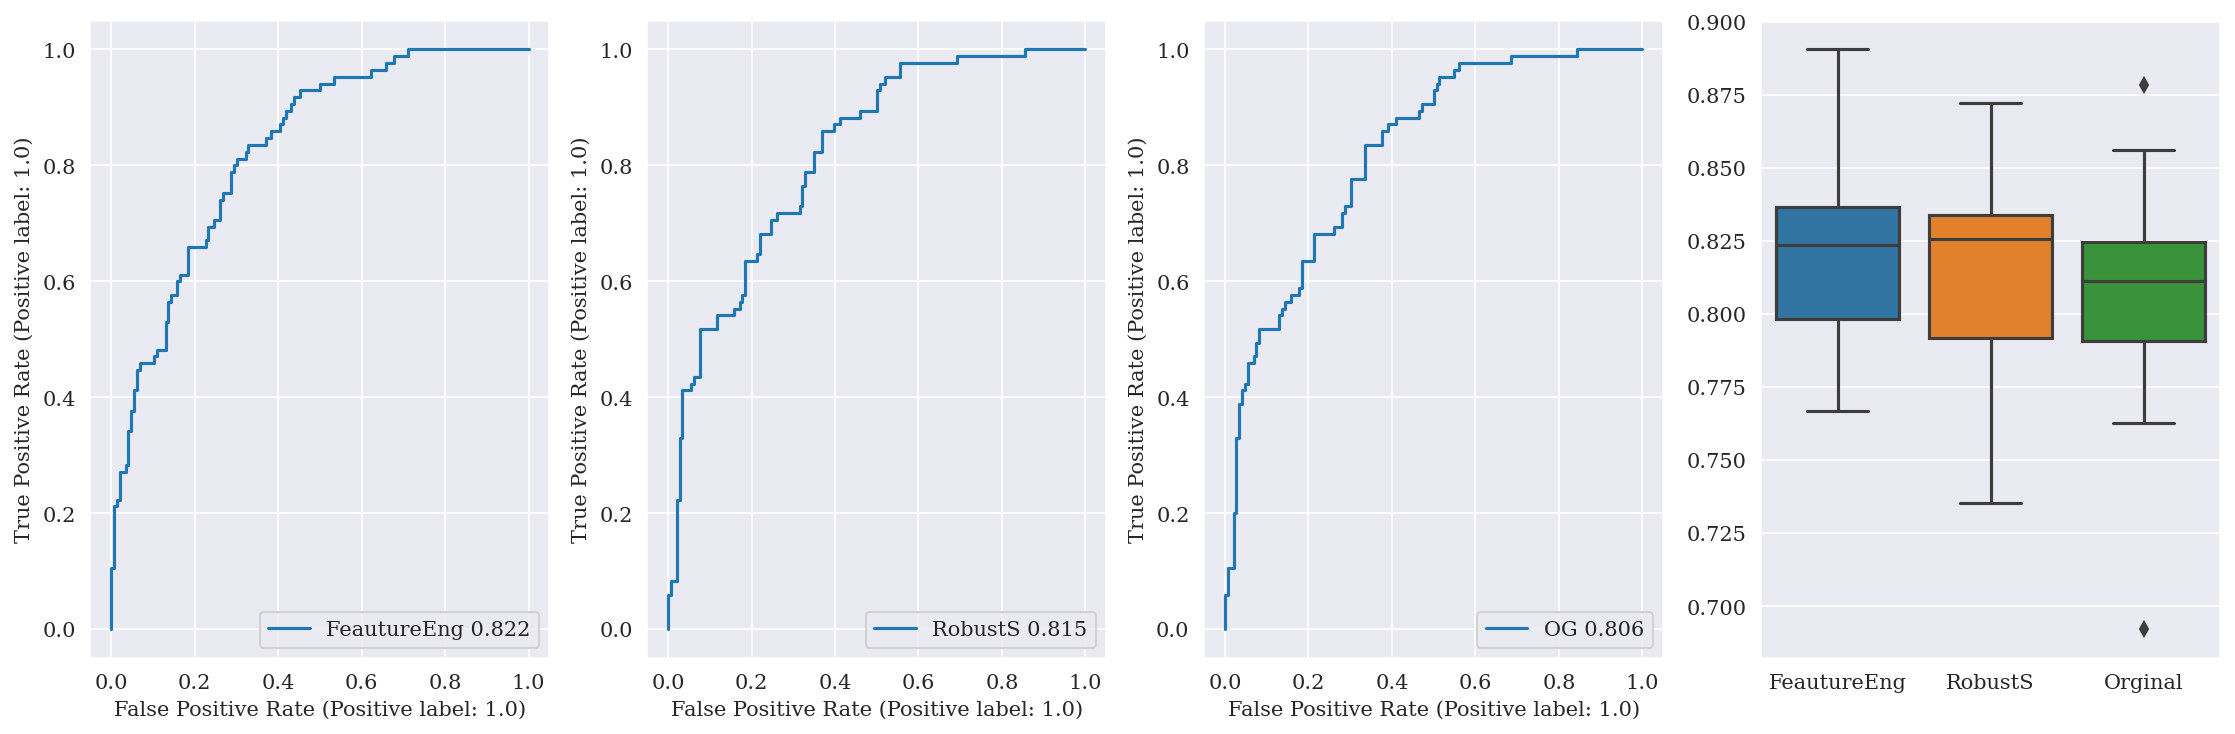

In [32]:
def logistic_regression_model(X_train, y_train, X_train1, X_valid, X_valid1, y_valid, data):
    """
    Fits two logistic regression models, one using X_train and the other using X_train1, to the given target variable y_train.
    Then, it evaluates the two models using `evaluate_model` function on X_valid and X_valid1.
    Finally, it plots the ROC curve for both models and displays the spread of scores using boxplots.
    """
    
    # splitting data (og dataset no transformations)
    OG_train, OG_valid = split_data(data, train_ratio=0.7)
    X_og_train, X_og_valid = OG_train.drop(columns=[8],axis=1),OG_valid.drop(columns=[8],axis=1)
    y_og_train, y_og_valid = OG_train[8],OG_valid[8]
    
    model1, model2, model3 = LogisticRegression(), LogisticRegression(), LogisticRegression()
    model1.fit(X_train, y_train)
    model2.fit(X_train1, y_train)
    model3.fit(X_og_train, y_og_train)
    
    scores_valid = evaluate_model(model1, X_valid, y_valid)
    auc = np.mean(scores_valid)
    scores_valid1 = evaluate_model(model2, X_valid1, y_valid)
    auc1 = np.mean(scores_valid1)
    scores_valid2 = evaluate_model(model3, X_og_valid, y_valid)
    auc2 = np.mean(scores_valid2)
    
    fig, ax = plt.subplots(1, 4, figsize=(15,5))
    plot_roc_curve(model1, X_valid, y_valid, ax=ax[0], label=f'FeautureEng {round(auc,3)}')
    plot_roc_curve(model2, X_valid1, y_valid, ax=ax[1], label=f'RobustS {round(auc1,3)}')
    plot_roc_curve(model3, X_og_valid, y_og_valid, ax=ax[2], label=f'OG {round(auc2,3)}')
    sns.boxplot(data=[scores_valid, scores_valid1,scores_valid2], ax=ax[3])
    ax[3].set_xticklabels(['FeautureEng', 'RobustS','Orginal'])
    plt.tight_layout()
    plt.show()

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    """
    Evaluates a given model using cross-validation. It repeats stratified k-fold cross validation 3 times with 10 splits each.
    
    Parameters:
        model (scikit-learn estimator): a scikit-learn model to be evaluated
        X (array-like): feature data
        y (array-like): target variable
        
    Returns:
        scores (array-like): an array of accuracy scores
    """
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return scores

logistic_regression_model(X_train, y_train, X_train1, X_valid, X_valid1, y_valid, data)

#### Conclusion:

In conclusion, the results of the roc_auc scores suggest that feature engineering has a significant impact on the performance of the model. Specifically, the best score of 0.822 was achieved with feature engineering without pre-processing, indicating that carefully crafted features can improve the model's ability to distinguish between positive and negative cases. While pre-processing with a robust scaler did result in a slightly lower score of 0.815, it may still be useful for improving model performance in certain scenarios. Finally, not applying any feature engineering resulted in the lowest score of 0.806, highlighting the importance of feature engineering for optimal model performance.